## Running the metric evaluation

In [ ]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install evaluate --quiet
!pip install sentencepiece --quiet
!pip install accelerate --quiet
!pip install rouge_score --quiet
!pip install bert_score --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 KB 2.6 MB/s eta 0:00:00


In [ ]:
!cp /content/drive/MyDrive/MscThesis/Evaluation_code/Bartscore.py /content

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle

import datasets
import evaluate
import accelerate

import Bartscore as bartscore


In [ ]:

def set_dataframe(model):
  path = '/content/drive/MyDrive/MscThesis/Generation_docs/mT5_Contrastive_Search/'

  data = pd.DataFrame()
  data["RDF"] = pd.read_csv(f'{path}/rdfs.txt', sep='delimiter', header=None, encoding='UTF-8')
  data["Predictions"] = pd.read_csv(f'{path}/decode_predictions.txt', sep='delimiter', header=None, encoding='UTF-8')
  data['Real'] = pd.read_csv(f'{path}/true_articles.txt', sep='delimiter', header=None, encoding='UTF-8')

  return data

In [ ]:
def load_eval_metrics():
    """
    Loads in all metrics that will be used later on during evaluation. This is seperated to not load in the metrics a dozen of times during training.
    """
    #bleu = datasets.load_metric("bleu")
    rouge = evaluate.load('rouge')
    meteor = evaluate.load('meteor')
    #perplexity = evaluate.load("perplexity", module_type="metric")
    #bertscore = evaluate.load("bertscore")
    bart_scorer = bartscore.BARTScorer(checkpoint='facebook/bart-base') 

    print('LOGGING: load_eval_metrics DONE \n')

    #return bleu, rouge, meteor, perplexity, bertscore, bart_scorer
    return rouge, meteor, bart_scorer

In [ ]:
def pickle_df(df, model_path):
  with open(f"{model_path}.pickle", 'wb') as f:
    pickle.dump(df, f)

In [ ]:
def postprocess_text(preds, labels):
    """
    Supplementary Method called in decode_text.

    Returns list of split decoded labels and predictions for evaluation
    """
    #preds = [pred.split(' ') for pred in preds]
    preds = [preds.split(' ')]
    labels = [[labels.split(' ')]]
    #labels = [[label.split()] for label in labels]
    return preds, labels

def evaluate_texts(decoded_preds, decoded_labels):
    """
    Calculates metrics given a list of decoded predictions and decoded labels
    """
    #post_process for BLEU
    #blue_preds, blue_labels = postprocess_text(decoded_preds,  decoded_labels)

    # setup metrics for use
    #bleu, rouge, meteor,perplexity, bertscore, bart_scorer = load_eval_metrics()
    decoded_preds = [decoded_preds]
    decoded_labels = [decoded_labels]

    #Calculate the metrics
    #print(f'\n LOGGING: Calculating Blue')
    #bleu_output = bleu.compute(predictions=blue_preds, references=blue_labels)
    #print(f'\n LOGGING: Calculating Rouge')
    rouge_output = rouge.compute(predictions=decoded_preds, references=decoded_labels)
    #print(f'\n LOGGING: Calculating Meteor')
    meteor_output = meteor.compute(predictions=decoded_preds, references=decoded_labels)
    #print(f'\n LOGGING: Calculating Perplexity')
    #perp_output = perplexity.compute(predictions=decoded_preds, model_id='gpt2')
    #print(f'\n LOGGING: Calculating Bertscore')
    #bertscore_output = bertscore.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    #print(f'\n LOGGING: Calculating Bartscore')
    bart_scores_output = bart_scorer.score(srcs=decoded_preds, tgts=decoded_labels, batch_size=16)

    #print(f'\n LOGGING: Done calculations')

    #return bleu_output, rouge_output, meteor_output, perp_output, bertscore_output, bart_scores_output
    return rouge_output, meteor_output, bart_scores_output


def Set_evaluation():

    paths = ["mT5_contrastive"]#, "T5-dutch_contrastive"]
    
    # setup metrics for use
    global bleu
    global rouge
    global meteor
    global perplexity
    global bertscore
    global bart_scorer
    
#    bleu, rouge, meteor,perplexity, bertscore, bart_scorer = load_eval_metrics()
    rouge, meteor, bart_scorer = load_eval_metrics()


    for model_results in paths:
      dataframe = set_dataframe(model_results)

      #dataframe = prepare_dataframe()
      #dataframe = data
      # dataframe['BLEU'], dataframe['ROUGE_1'], dataframe['ROUGE_2'], dataframe['ROUGE_L'],dataframe['METEOR']  =np.nan, np.nan, np.nan, np.nan, np.nan
      # dataframe['Perplexity'], dataframe['Bert_precision'], dataframe['Bert_recall'], dataframe['Bert_f1'],dataframe['BartScore'] =np.nan, np.nan, np.nan, np.nan, np.nan

      bleu_list, rouge_1, rouge_2, rouge_l, meteor_list, perplexity_list, bert_precision, bert_recall, bert_f1, bartscore = [], [], [],[],[],[],[],[],[],[]


      # Use itertuples, as it is 83x faster than iterrows
      for row in dataframe.itertuples():
        print(row[0])
        if row[0] % 100 == 0:
          print(f'\n\nNEXT 100 REACHED! \n\n')
        ## Calculate each metric
        #bleu_output, rouge_output, meteor_output, perp_output, bertscore_output, bart_scores_output = evaluate_texts(row[2], row[3])
        rouge_output, meteor_output, bart_scores_output = evaluate_texts(row[2], row[3])

        #bleu_list.append(bleu_output["bleu"])
        rouge_1.append(rouge_output['rouge1'])
        rouge_2.append(rouge_output['rouge2'])
        rouge_l.append(rouge_output['rougeL'])
        meteor_list.append(meteor_output['meteor'])
        #perplexity_list.append(perp_output['perplexities'][0])
        #bert_precision.append(bertscore_output['precision'][0])
        #bert_recall.append(bertscore_output['recall'][0])
        #bert_f1.append(bertscore_output['f1'][0])
        bartscore.append(bart_scores_output[0] )


      print(f"\n\n calculations done \n\n")             

      #dataframe['BLUE'] = bleu_list
      dataframe['Rouge 1'] = rouge_1
      dataframe['Rouge 2'] = rouge_2
      dataframe['RougeL'] = rouge_l
      dataframe['Meteor'] = meteor_list
      #dataframe['Perplexity'] = perplexity_list
      #dataframe['Bert_precision'] = bert_precision
      #dataframe['Bert_recall'] = bert_recall
      #dataframe['Bert_f1'] = bert_f1
      dataframe['BartScore'] = bartscore


      pickle_df(dataframe, model_results)


In [ ]:
Set_evaluation()

## Sorting based on metric values

In [ ]:
import pandas as pd
import numpy as np
import pickle
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/T5-dutch.pickle', 'rb')
# dump information to that file
dutch_df = pickle.load(file)
# close the file
file.close()

In [ ]:
dutch_df.head()

In [ ]:
#dutch_df['Parent_F1'] = t5_dutch_parent

In [ ]:
dutch_df.head()

In [ ]:
test_df = dutch_df.copy(deep=True)

In [ ]:
test_df = test_df.sort_values("BartScore")

In [ ]:
test_df.head()

In [ ]:
test_df.tail()

In [ ]:
test_df[0:50]

In [ ]:
single_df = test_df.loc[test_df['RDF'].str.len() == 1]

In [ ]:
single_df.head()

In [ ]:
import re
test_df['RDF'] = test_df['RDF'].apply(lambda x: len(re.findall(r'\w+', x)))

In [ ]:
test_df.head()

In [ ]:
test_df['test'] = test_df['RDF'].apply(lambda x: x.count('),') + 1)

In [ ]:
test_df.head()

In [ ]:
test_df['RDF'][4]

In [ ]:
test_df['RDF'] = test_df['RDF'].str.split()

In [ ]:
test_df = test_df.sort_values(["BartScore", "Parent_F1" ,"Meteor", "RougeL"])

In [ ]:
test_df['Length'] = test_df.RDF.map(len)

In [ ]:
test_df.head()

In [ ]:
test_df.iloc[-10:-5]

In [ ]:
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/T5-dutch.pickle', 'rb')
# dump information to that file
dutch_df = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/mT5.pickle', 'rb')
# dump information to that file
mt5_df = pickle.load(file)
# close the file
file.close()

In [ ]:
mt5_df['Parent_F1'] = mt5_parent_f1

In [ ]:
mt5_df.head()

In [ ]:
mt5_df= mt5_df.sort_values(["BartScore", "Parent_F1" ,"Meteor", "RougeL"])
mt5_df.head()

In [ ]:
mt5_df.iloc[-500:-400]

In [ ]:
mt5_worst_100 = mt5_df.iloc[:100]
mt5_500_400_best = mt5_df.iloc[-500:-400]
t5_dutch_worst_100 = test_df.iloc[:100]
t5_dutch_500_400_best = test_df.iloc[-500:-400]

In [ ]:
mt5_worst_100.to_csv(r'/content/drive/MyDrive/MscThesis/mt5_worst_100.csv', index = False, header=True, encoding='utf-8')
mt5_500_400_best.to_csv(r'/content/drive/MyDrive/MscThesis/mt5_500_400_best.csv', index = False, header=True, encoding='utf-8')
t5_dutch_worst_100.to_csv(r'/content/drive/MyDrive/MscThesis/t5_dutch_worst_100.csv', index = False, header=True, encoding='utf-8')
t5_dutch_500_400_best.to_csv(r'/content/drive/MyDrive/MscThesis/t5_dutch_500_400_best.csv', index = False, header=True, encoding='utf-8')

uitgebreide set van professionele tools voor de Forex, Grondstoffen, Futures en de Aandelenmarkt inclusief real-time data streaming, een uitgebreide economische kalender, maar ook financieel nieuws en technische & fundamentele Beurs analyses van in-house experts.Lees meer nieuws over Investing.com Nederland en download de nieuwe Investing.com App voor Android!"


# Post eval research


### Initial Search

In [ ]:
import pandas as pd
import numpy as np
import pickle

In [ ]:
mt5_worst_df = pd.DataFrame()
mt5_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/mt5_500_400_best.xlsx')


In [ ]:
mt5_worst_df.describe()

In [ ]:
mt5_worst_df.head()

In [ ]:
mt5_worst_df.info()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [ ]:
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/T5-dutch.pickle', 'rb')
# dump information to that file
dutch_df = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/mT5.pickle', 'rb')
# dump information to that file
mt5_df = pickle.load(file)
# close the file
file.close()

In [ ]:
fig, axs = plt.subplots(2,2)

plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('mT5 total', fontsize=32)

mt5_df.hist(column='BartScore', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
mt5_df.hist(column='Bert_f1', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
mt5_df.hist(column='Meteor', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
mt5_df.hist(column='RougeL', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

In [ ]:
fig, axs = plt.subplots(2,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5-dutch total', fontsize=32)

dutch_df.hist(column='BartScore', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
dutch_df.hist(column='Bert_f1', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
dutch_df.hist(column='Meteor', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
dutch_df.hist(column='RougeL', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

In [ ]:
mt5_good_df = pd.DataFrame()
mt5_good_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/mt5_500_400_best.xlsx')

t5_good_df = pd.DataFrame()
t5_good_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/t5_dutch_500_400_best.xlsx')

mt5_worst_df = pd.DataFrame()
mt5_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/mt5_worst_100.xlsx')

t5_worst_df = pd.DataFrame()
t5_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/t5_dutch_worst_100.xlsx')

In [ ]:
fig, axs = plt.subplots(4,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('mT5-dutch Worst 100 Results', fontsize=32)

mt5_worst_df.hist(column='BartScore', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
mt5_worst_df.hist(column='Bert_f1', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
mt5_worst_df.hist(column='Meteor', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
mt5_worst_df.hist(column='RougeL', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

mt5_worst_df.hist(column='Hallucinations', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][0])
mt5_worst_df.hist(column='Ommisions', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][1])
mt5_worst_df.hist(column='Duplications', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][0])
mt5_worst_df.hist(column='No Generation', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][1])

In [ ]:
fig, axs = plt.subplots(4,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5 Worst 100 Results', fontsize=32)

t5_worst_df.hist(column='BartScore', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
t5_worst_df.hist(column='Bert_f1', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
t5_worst_df.hist(column='Meteor', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
t5_worst_df.hist(column='RougeL', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

t5_worst_df.hist(column='Hallucinations', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][0])
t5_worst_df.hist(column='Ommisions', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][1])
t5_worst_df.hist(column='Duplications', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][0])
t5_worst_df.hist(column='No Generation', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][1])

In [ ]:
fig, axs = plt.subplots(4,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('mT5-dutch Good 100 Results', fontsize=32)

mt5_good_df.hist(column='BartScore', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
mt5_good_df.hist(column='Bert_f1', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
mt5_good_df.hist(column='Meteor', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
mt5_good_df.hist(column='RougeL', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

mt5_good_df.hist(column='Hallucinations', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][0])
mt5_good_df.hist(column='Ommisions', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][1])
mt5_good_df.hist(column='Duplications', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][0])
mt5_good_df.hist(column='No Generation', bins=25,color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][1])

In [ ]:
fig, axs = plt.subplots(4,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5-dutch Good 100 Results', fontsize=16)

t5_good_df.hist(column='BartScore', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
t5_good_df.hist(column='Bert_f1', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
t5_good_df.hist(column='Meteor', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
t5_good_df.hist(column='RougeL', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

t5_good_df.hist(column='Hallucinations', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][0])
t5_good_df.hist(column='Ommisions', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][1])
t5_good_df.hist(column='Duplications', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][0])
t5_good_df.hist(column='No Generation', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][1])

In [ ]:
import re
t5_good_df['Prediction length'] = t5_good_df['Predictions'].apply(lambda x: len(re.findall(r'\w+', x)))
mt5_good_df['Prediction length'] = mt5_good_df['Predictions'].apply(lambda x: len(re.findall(r'\w+', x)))
mt5_worst_df['Prediction length'] = mt5_worst_df['Predictions'].apply(lambda x: len(re.findall(r'\w+', x)))
t5_worst_df['Prediction length'] = t5_worst_df['Predictions'].apply(lambda x: len(re.findall(r'\w+', x)))


In [ ]:
fig, axs = plt.subplots(2,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('Prediction lengths (Left good, Right bad)', fontsize=16)

t5_good_df.hist(column='Prediction length', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
t5_worst_df.hist(column='Prediction length', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
mt5_good_df.hist(column='Prediction length', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
mt5_worst_df.hist(column='Prediction length',  bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

In [ ]:
## Dit wordt niet goed gedaan!!! Maar 2 elementen lijken 1 rdf count te hebben, echter is dat veel meer

t5_good_df['RDF_Count T5 good'] = t5_good_df['RDF'].apply(lambda x: x.count('")') + 1)
mt5_good_df['RDF_Count Mt5 good'] = mt5_good_df['RDF'].apply(lambda x: x.count('),') + 1)
mt5_worst_df['RDF_Count mt5 bad'] = mt5_worst_df['RDF'].apply(lambda x: x.count('),') + 1)
t5_worst_df['RDF_Count t5 bad'] = t5_worst_df['RDF'].apply(lambda x: x.count('")') + 1)

In [ ]:
fig, axs = plt.subplots(2,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5-dutch Good 100 Results', fontsize=16)

t5_good_df.hist(column='RDF_Count T5 good', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
t5_worst_df.hist(column='RDF_Count t5 bad', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
mt5_good_df.hist(column='RDF_Count Mt5 good', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
mt5_worst_df.hist(column='RDF_Count mt5 bad',  bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])


## Looking at the worst sets

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [ ]:
mt5_worst_df = pd.DataFrame()
mt5_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/mt5_worst_100.xlsx')

t5_worst_df = pd.DataFrame()
t5_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/t5_dutch_worst_100.xlsx')

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


#### t5-Dutch

In [ ]:
t5_worst_df.head()

,RDF,Predictions,Real,BLUE,Rouge 1,Rouge 2,RougeL,Meteor,Perplexity,Bert_precision,...,No Generation,Incorrect Number,Incorrect Named Entity,Incorrect Word,Incorrect Addition,Context Error,Wrong Language,Not Checkable,Other,Comments
0,"['[(""\'locationName"",', '""New', 'York\'"")]']",New York,New York - De argumenten voor een renteverlagi...,0.0,1.379310e+16,7.407407e+15,1.379310e+16,6.672598e+15,6.789276e+15,9.178623e+15,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Only location name is given, but dissapointing..."
1,"['[(""\'hasWonTeam"",', '""ADO\'"")]']",ADO -,ADO boekte daardoor opnieuw een knappe overwin...,0.0,1.428571e+16,0.000000e+00,1.428571e+16,3.906250e+05,5.645878e+15,8.586638e+13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Poor generation, the input gives a hint that t..."
2,"['[(""\'locationName"",', '""Wall', 'Street\'"")]']",Wall Street,Een dag na een uiterst beroerde sessie maakt W...,0.0,2.500000e+01,1.428571e+16,2.500000e+01,1.368613e+16,1.948564e+16,9.160118e+15,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Only location name is given, but dissapointing..."
3,"['[(""\'locationName"",', '""VS.\'"")]']",De VS.,Trump zei echter niet bang te zijn voor een la...,0.0,1.904762e+15,1.052632e+16,1.904762e+15,1.533565e+16,3.829755e+15,8.953006e+15,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"Only location name is given, but dissapointing..."
4,"['[(""\'playerName"",', '""Guardado\'"")]']",Guardado was not amused.,Weer Guardado mocht het zich aantrekken dat hi...,0.0,9.523810e+15,0.000000e+00,9.523810e+15,5.988024e+15,2.669692e+13,8.959678e+15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Predictions has more generation that purely in...


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d38e96590>],
      dtype=object)

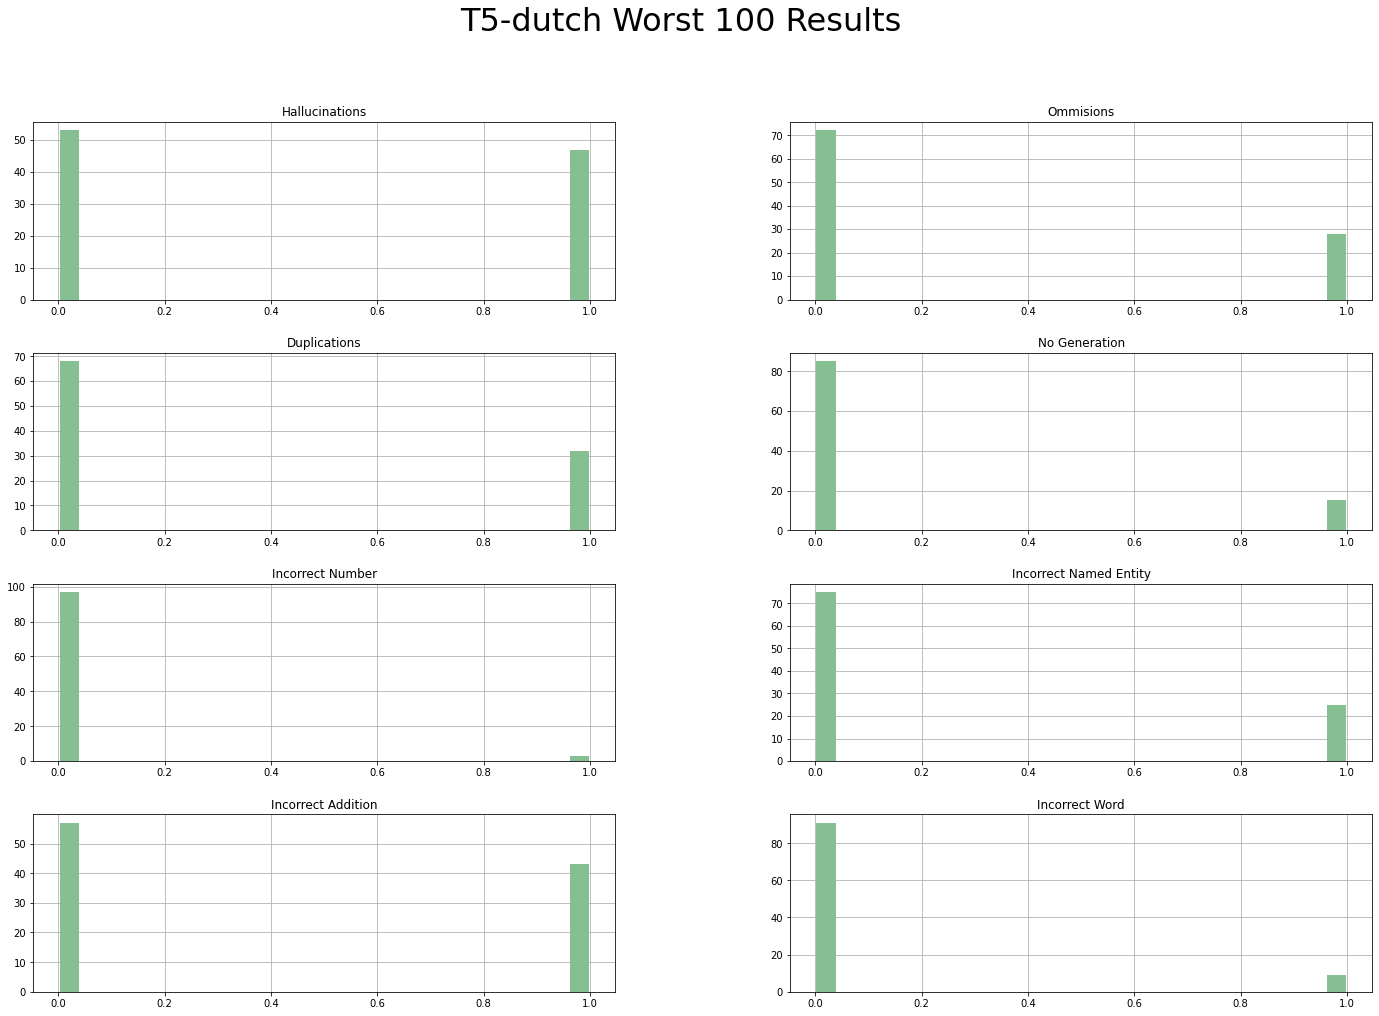

In [ ]:
fig, axs = plt.subplots(4,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5-dutch Worst 100 Results', fontsize=32)

t5_worst_df.hist(column='Hallucinations', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
t5_worst_df.hist(column='Ommisions', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
t5_worst_df.hist(column='Duplications', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
t5_worst_df.hist(column='No Generation', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

t5_worst_df.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][0])
t5_worst_df.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][1])
t5_worst_df.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][0])
t5_worst_df.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][1])

In [ ]:
#contains_hallucination_df =  t5_worst_df['Hallucinations']==1

contains_hallucination_df = t5_worst_df[t5_worst_df.Hallucinations.eq(1)]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d39bf3d90>],
      dtype=object)

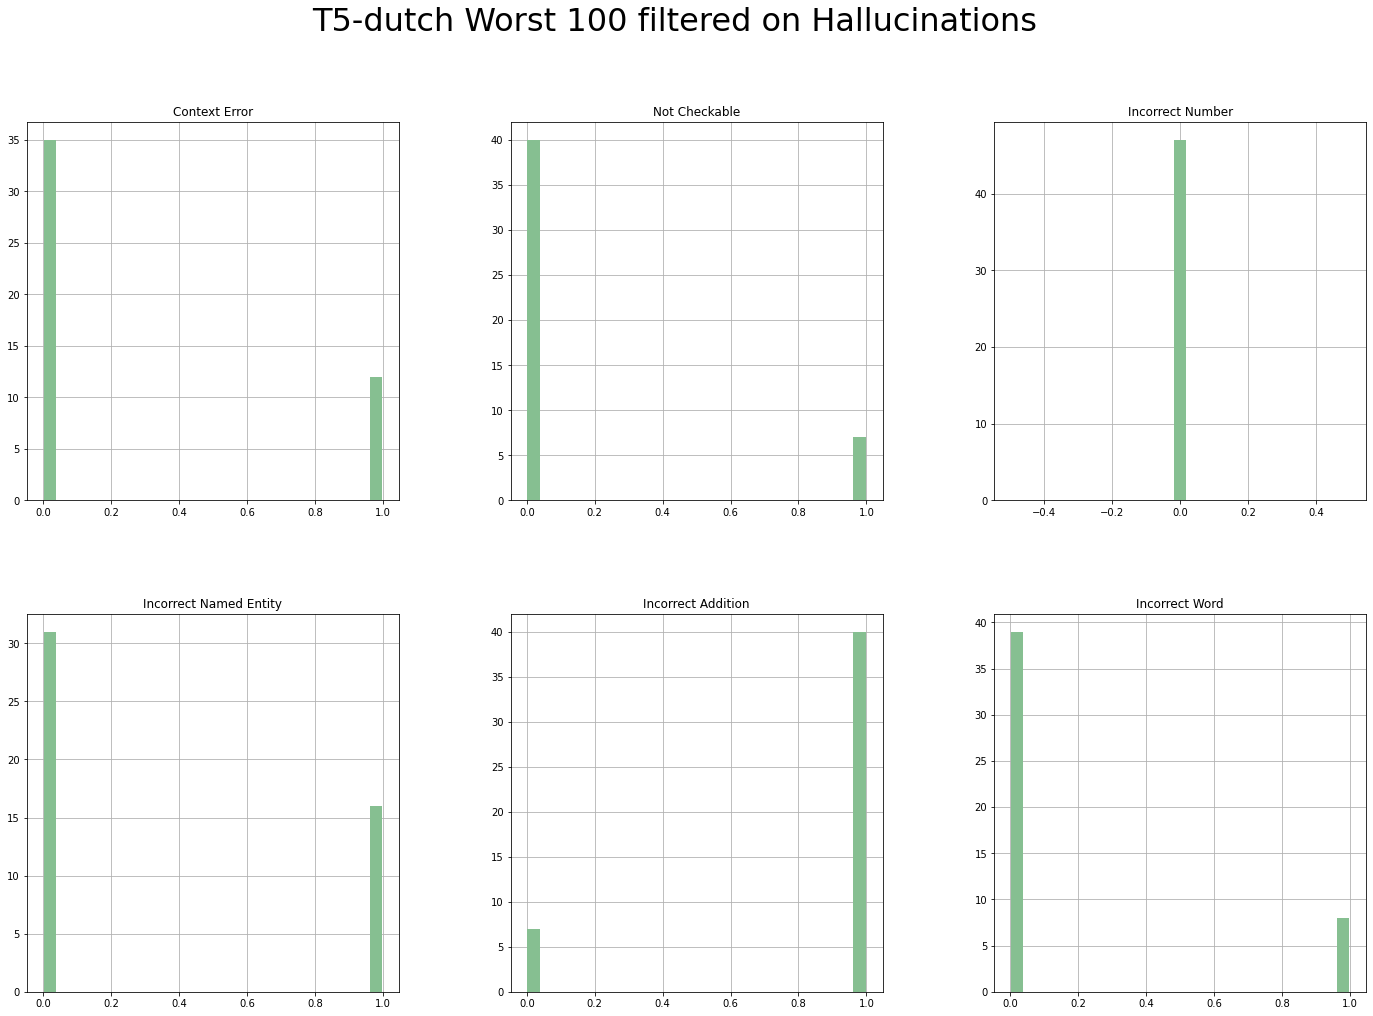

In [ ]:
fig, axs = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5-dutch Worst 100 filtered on Hallucinations', fontsize=32)


contains_hallucination_df.hist(column='Context Error', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
contains_hallucination_df.hist(column='Not Checkable', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
contains_hallucination_df.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][2])
contains_hallucination_df.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
contains_hallucination_df.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])
contains_hallucination_df.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][2])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d397c94d0>],
      dtype=object)

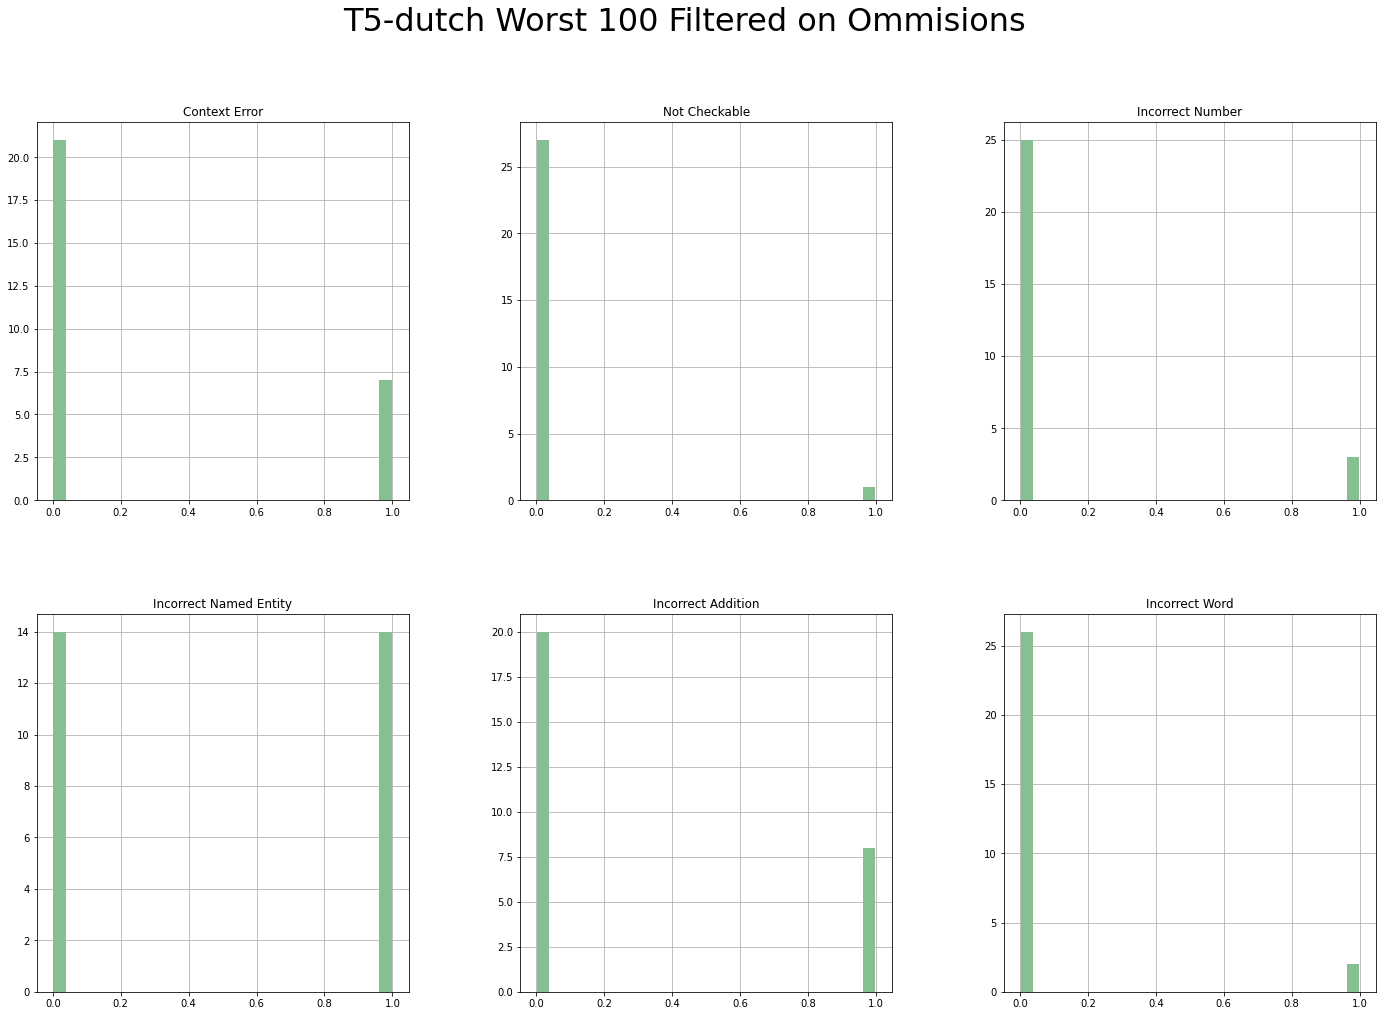

In [ ]:
contains_hallucination_df = t5_worst_df[t5_worst_df.Ommisions.eq(1)]

fig, axs = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5-dutch Worst 100 Filtered on Ommisions', fontsize=32)


contains_hallucination_df.hist(column='Context Error', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
contains_hallucination_df.hist(column='Not Checkable', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
contains_hallucination_df.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][2])
contains_hallucination_df.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
contains_hallucination_df.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])
contains_hallucination_df.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][2])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d3936ea50>],
      dtype=object)

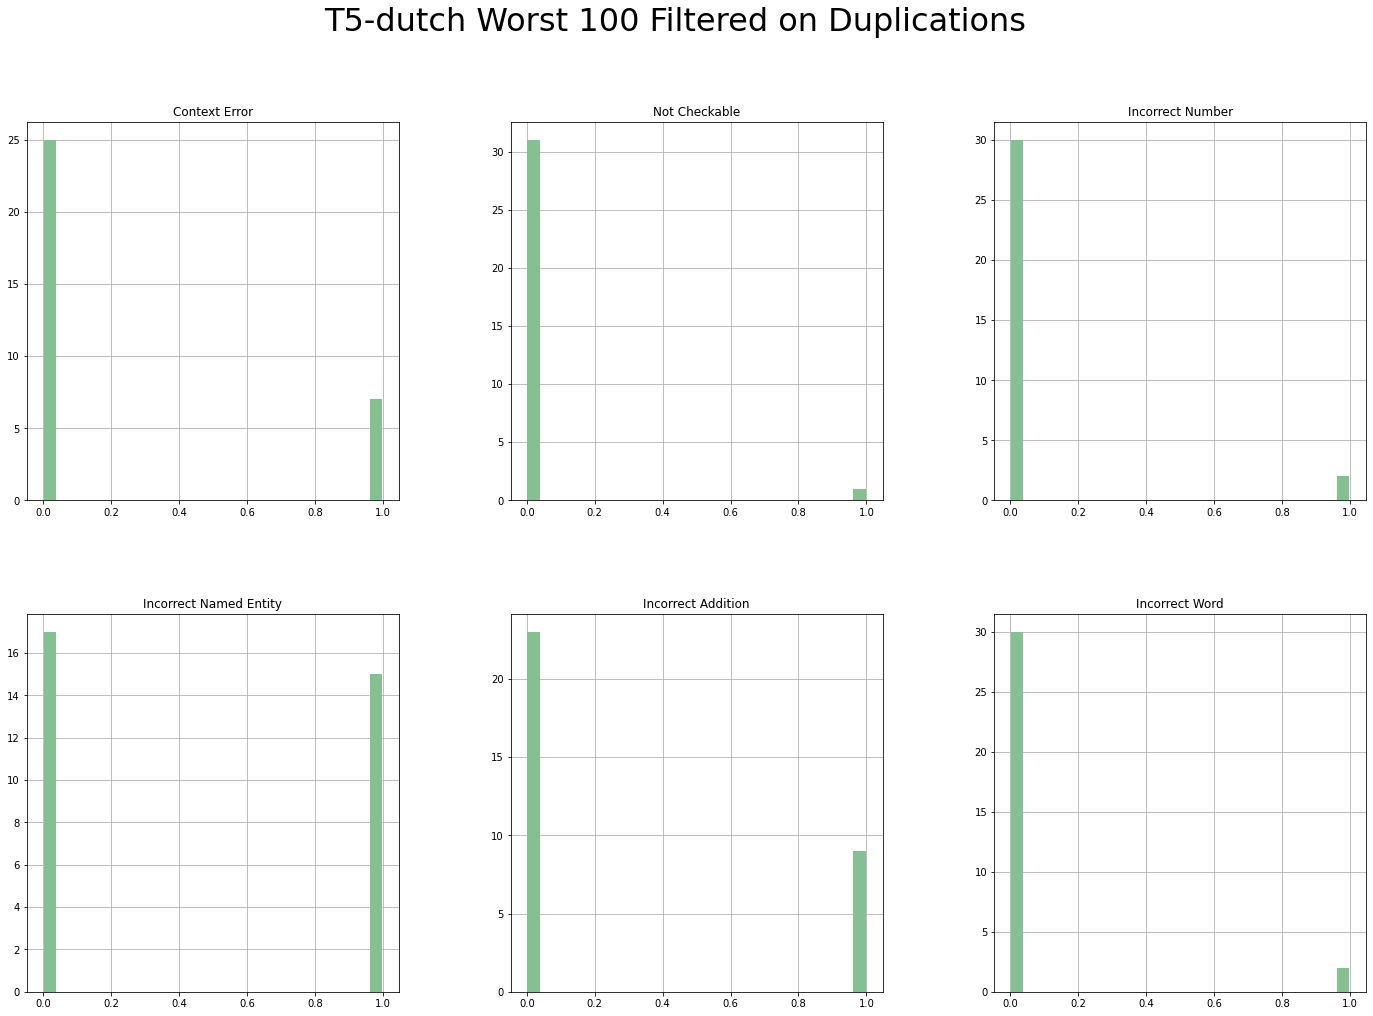

In [ ]:
contains_hallucination_df = t5_worst_df[t5_worst_df.Duplications.eq(1)]

fig, axs = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('T5-dutch Worst 100 Filtered on Duplications', fontsize=32)


contains_hallucination_df.hist(column='Context Error', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
contains_hallucination_df.hist(column='Not Checkable', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
contains_hallucination_df.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][2])
contains_hallucination_df.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
contains_hallucination_df.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])
contains_hallucination_df.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][2])

#### mT5

In [ ]:
mt5_worst_df.head()

,RDF,Predictions,Real,BLUE,Rouge 1,Rouge 2,RougeL,Meteor,Perplexity,Bert_precision,...,No Generation,Incorrect Number,Incorrect Named Entity,Incorrect Word,Incorrect Addition,Context Error,Wrong Language,Not Checkable,Other,Comments
0,"[(""'locationName"", ""New York'"")]",New York,New York - De argumenten voor een renteverlagi...,0,1.379310e+16,7407407407407407,1.379310e+16,6672597864768683,6789276123046875,9178622961044312,...,1,0,0,0,0,0,0,0,0,"Only location name is given, but dissapointing..."
1,"[(""'companyName"", ""CNBC'"")]",CNBC,Het bedrijf moet mensen beter toegang bieden t...,0,8.333333e+15,0,8.333333e+15,22123893805309736,3048608093261719,8398118019104004,...,1,0,0,0,0,0,0,0,0,"Only company name is given, but dissapointing ..."
2,"[(""'locationName"", ""Wall Street'"")]",Wall Street,Een dag na een uiterst beroerde sessie maakt W...,0,2.500000e+01,14285714285714288,2.500000e+01,13686131386861314,19485643005371096,9160118103027344,...,1,0,0,0,0,0,0,0,0,"Only location name is given, but dissapointing..."
3,"[(""'victimAge Group"", ""minor'""), (""'victimGend...","Another minor female, a Hispanic female, was s...",A Hispanic female minor,0,3.478261e+16,1904761904761905,2.608696e+15,5349576271186441,28812692642211912,8533715009689331,...,0,0,0,0,1,0,0,0,0,"Slight duplication, also hallucination of type..."
4,"[(""'companyName"", ""Sandd'"")]",Sandd,De overname van rivaal Sandd drukte duidelijk ...,0,1.428571e+16,0,1.428571e+16,3937007874015748,33873330078125,8561487197875977,...,1,0,0,0,0,0,0,0,0,"Only company name is given, but dissapointing ..."


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d38987710>],
      dtype=object)

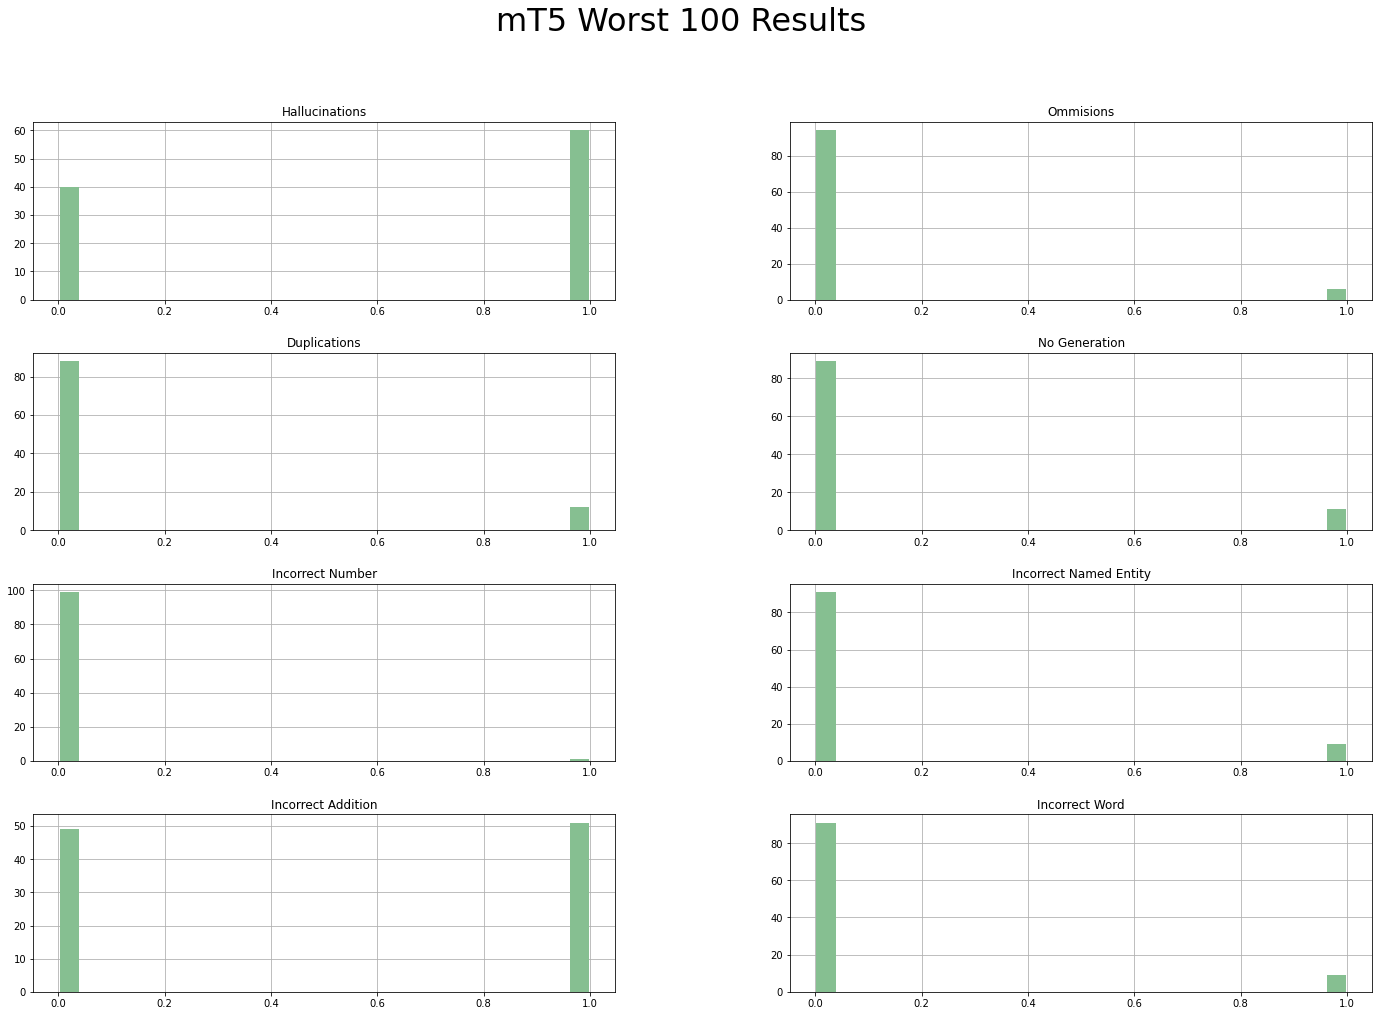

In [ ]:
fig, axs = plt.subplots(4,2)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('mT5 Worst 100 Results', fontsize=32)

mt5_worst_df.hist(column='Hallucinations', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
mt5_worst_df.hist(column='Ommisions', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
mt5_worst_df.hist(column='Duplications', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
mt5_worst_df.hist(column='No Generation', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])

mt5_worst_df.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][0])
mt5_worst_df.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[2][1])
mt5_worst_df.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][0])
mt5_worst_df.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[3][1])

In [ ]:
#contains_hallucination_df =  t5_worst_df['Hallucinations']==1

contains_hallucination_df_mt5 = mt5_worst_df[mt5_worst_df.Hallucinations.eq(1)]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d38477c10>],
      dtype=object)

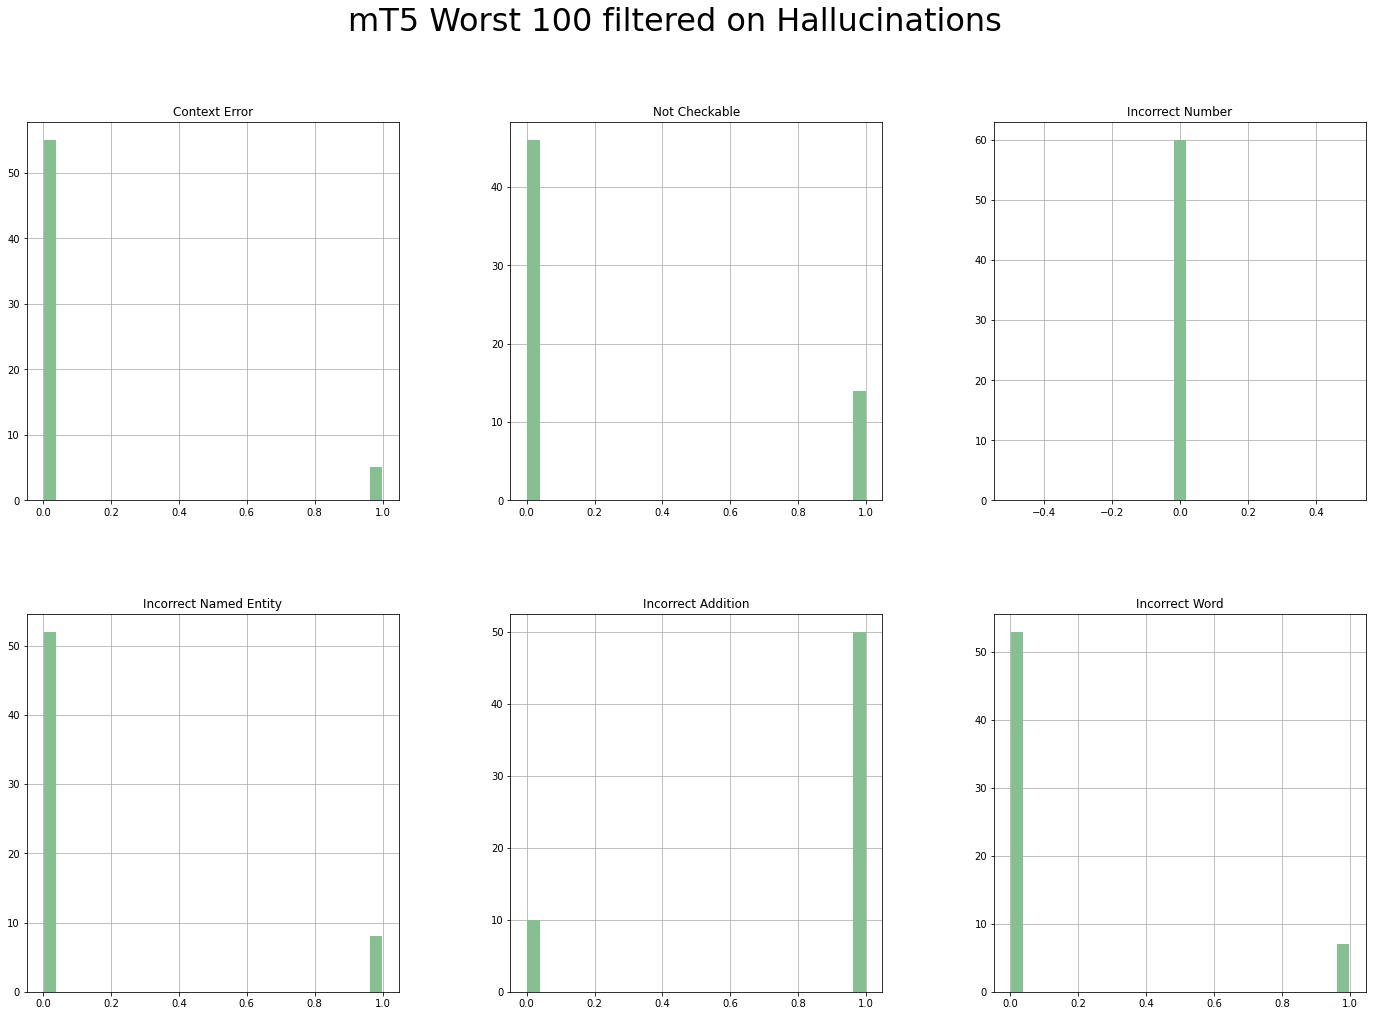

In [ ]:
fig, axs = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('mT5 Worst 100 filtered on Hallucinations', fontsize=32)


contains_hallucination_df_mt5.hist(column='Context Error', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
contains_hallucination_df_mt5.hist(column='Not Checkable', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
contains_hallucination_df_mt5.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][2])
contains_hallucination_df_mt5.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
contains_hallucination_df_mt5.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])
contains_hallucination_df_mt5.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][2])

[("'ORG", "JPMorgan Chase'")]

JPMorgan Chase said it would coordinate a deal with JPMorgan Chase on a joint equity agreement with JPMorgan Chase.

Despite the increased unreliability and vastly different economic backdrop, traders should follow the precedent seen in the Clinton era and allay their fears, JPMorgan Chase head of cross-asset strategy John Normand said.

['[("\'ORDINAL",', '"182mn\'"),', '("\'ORDINAL",', '"39m\'"),', '("\'ORG",', '"BOP\'"),', '("\'ORG",', '"FCCL\'"),', '("\'ORG",', '"UNITY\'")]']

The UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UNITY UN"

Major contribution to total market volume came from BOP, FCCL, and UNITY churning 39m shares out of the total market share of 182mn shares."

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d3807ae10>],
      dtype=object)

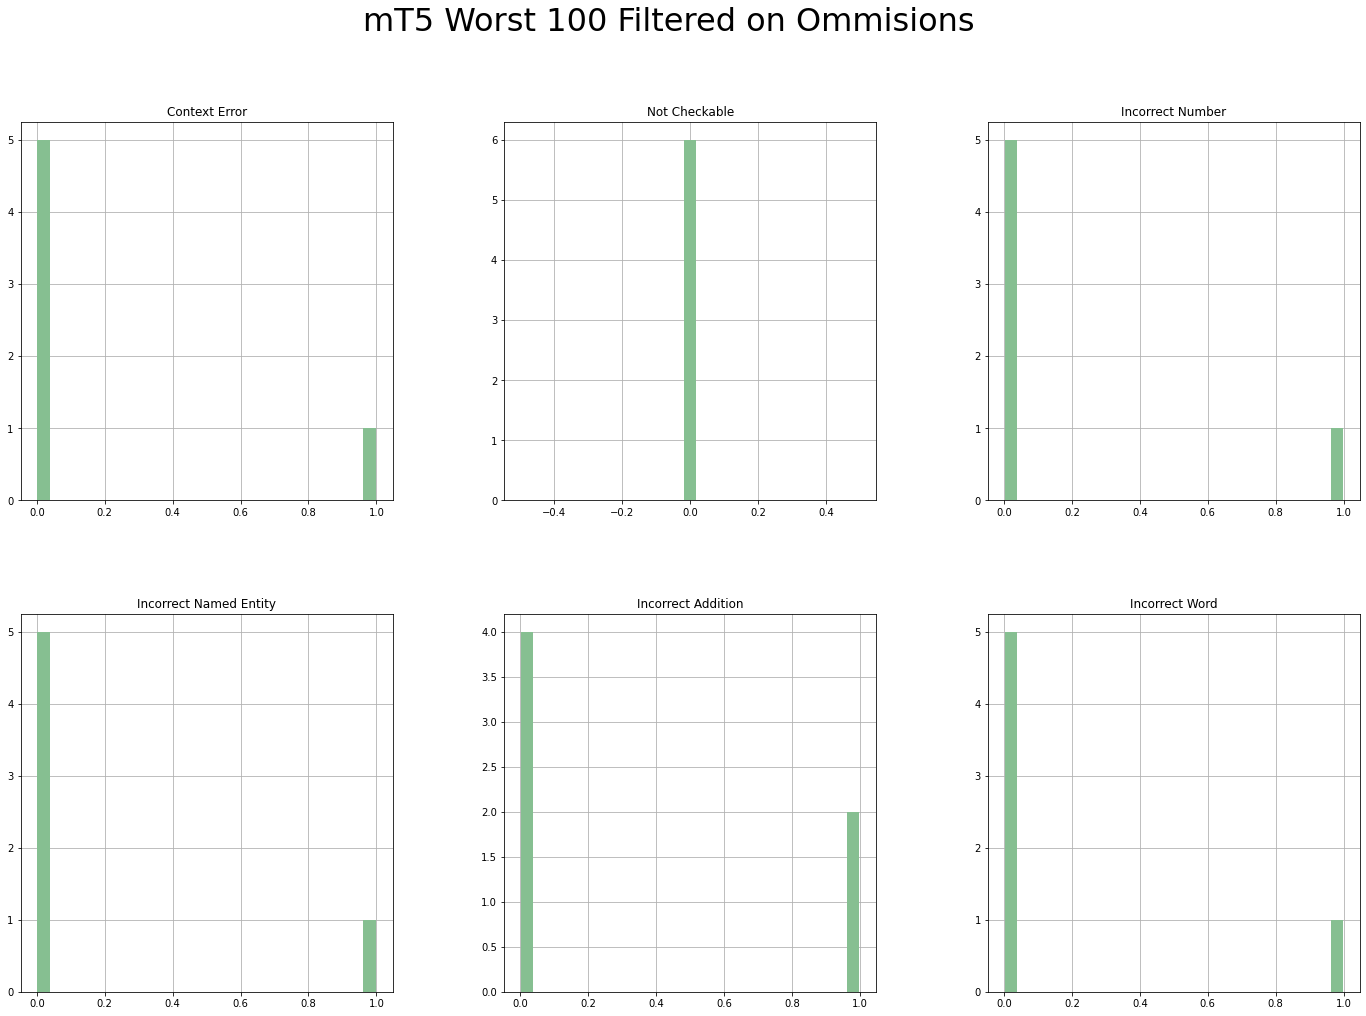

In [ ]:
contains_hallucination_df_mt5 = mt5_worst_df[mt5_worst_df.Ommisions.eq(1)]

fig, axs = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('mT5 Worst 100 Filtered on Ommisions', fontsize=32)


contains_hallucination_df_mt5.hist(column='Context Error', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
contains_hallucination_df_mt5.hist(column='Not Checkable', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
contains_hallucination_df_mt5.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][2])
contains_hallucination_df_mt5.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
contains_hallucination_df_mt5.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])
contains_hallucination_df_mt5.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][2])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1d37c2d090>],
      dtype=object)

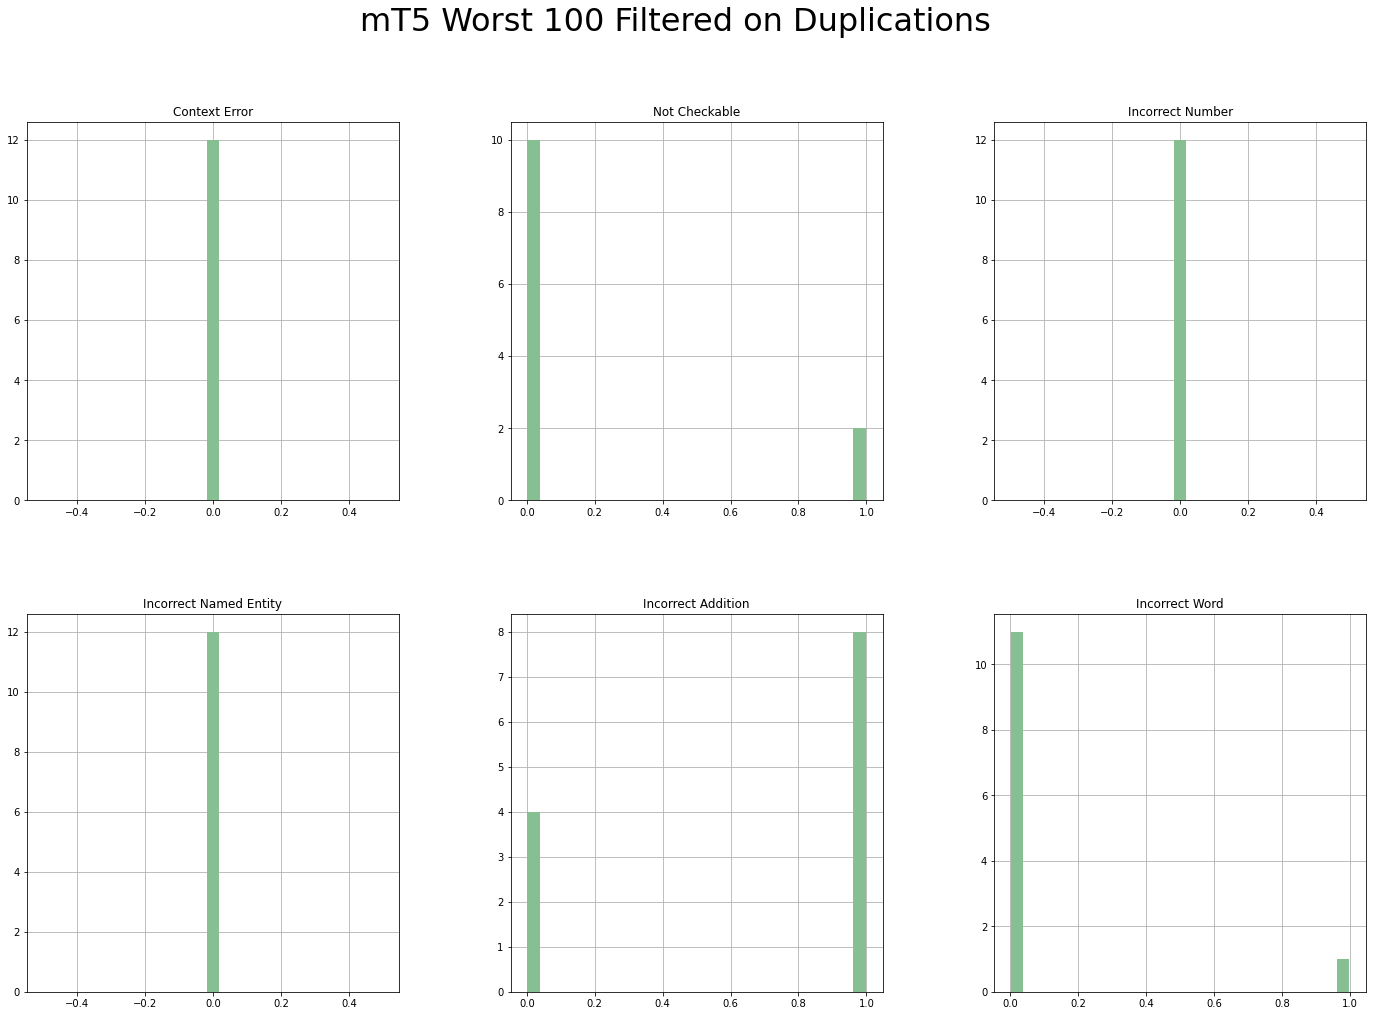

In [ ]:
contains_hallucination_df_mt5 = mt5_worst_df[mt5_worst_df.Duplications.eq(1)]

fig, axs = plt.subplots(2,3)
plt.rcParams["figure.figsize"] = (24,16)
fig.suptitle('mT5 Worst 100 Filtered on Duplications', fontsize=32)


contains_hallucination_df_mt5.hist(column='Context Error', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][0])
contains_hallucination_df_mt5.hist(column='Not Checkable', bins=25,   color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][1])
contains_hallucination_df_mt5.hist(column='Incorrect Number', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[0][2])
contains_hallucination_df_mt5.hist(column='Incorrect Named Entity', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][0])
contains_hallucination_df_mt5.hist(column='Incorrect Addition', bins=25, color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][1])
contains_hallucination_df_mt5.hist(column='Incorrect Word', bins=25,  color='#86bf91', zorder=2, rwidth=0.9, ax=axs[1][2])

# Elongating RDF and True articles to match the 5 generated in Beam search

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

In [ ]:
#### T5 Beam search with 5 generations

rdf = pd.DataFrame()
rdf["RDF"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Generation_docs/DutchT5_Beam_Search_5/rdfs.txt', sep='delimiter', header=None, encoding='UTF-8')

target_text = pd.DataFrame()
target_text["Target"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Generation_docs/DutchT5_Beam_Search_5/true_articles.txt', sep='delimiter', header=None, encoding='UTF-8')
#multiple_generation_df["Predictions"] = pd.read_csv(f'{path}{model}/Output Examples/decode_predictions.txt', sep='delimiter', header=None, encoding='UTF-8')
#multiple_generation_df['Real'] = pd.read_csv(f'{path}{model}/Output Examples/true_articles.txt', sep='delimiter', header=None, encoding='UTF-8')

rdf_multiplied = pd.DataFrame(np.repeat(rdf.values, 5, axis=0))
rdf_multiplied.columns = rdf.columns

target_text_multiplied = pd.DataFrame(np.repeat(target_text.values, 5, axis=0))
target_text_multiplied.columns = target_text.columns

Full_df_t5 = pd.DataFrame()

Full_df_t5['RDF'] = rdf_multiplied
Full_df_t5["Predictions"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Generation_docs/DutchT5_Beam_Search_5/decode_predictions.txt', sep='delimiter', header=None, encoding='UTF-8')
Full_df_t5['Target'] = target_text_multiplied



In [ ]:
#### mT5 Beam search with 5 generations

rdf = pd.DataFrame()
rdf["RDF"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Generation_docs/mT5_Beam_Search_5/rdfs.txt', sep='delimiter', header=None, encoding='UTF-8')

target_text = pd.DataFrame()
target_text["Target"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Generation_docs/mT5_Beam_Search_5/true_articles.txt', sep='delimiter', header=None, encoding='UTF-8')
#multiple_generation_df["Predictions"] = pd.read_csv(f'{path}{model}/Output Examples/decode_predictions.txt', sep='delimiter', header=None, encoding='UTF-8')
#multiple_generation_df['Real'] = pd.read_csv(f'{path}{model}/Output Examples/true_articles.txt', sep='delimiter', header=None, encoding='UTF-8')

rdf_multiplied = pd.DataFrame(np.repeat(rdf.values, 5, axis=0))
rdf_multiplied.columns = rdf.columns

target_text_multiplied = pd.DataFrame(np.repeat(target_text.values, 5, axis=0))
target_text_multiplied.columns = target_text.columns

Full_df_mt5 = pd.DataFrame()

Full_df_mt5['RDF'] = rdf_multiplied
Full_df_mt5["Predictions"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Generation_docs/mT5_Beam_Search_5/decode_predictions.txt', sep='delimiter', header=None, encoding='UTF-8')
Full_df_mt5['Target'] = target_text_multiplied

In [ ]:
with open(f"Full_df_mt5.pickle", 'wb') as f:
  pickle.dump(Full_df_mt5, f)

# Getting the worst 100 generations for comparison



In [ ]:
import pandas as pd
import numpy as np
import pickle
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/T5d_all_beamSearch_one_generations..pickle', 'rb')
# dump information to that file
dutch_df = pickle.load(file)
# close the file
file.close()


# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/T5d_all_beamSearch_five_generations.pickle', 'rb')
# dump information to that file
five_beam_dutch_df = pickle.load(file)
# close the file
file.close()


# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/mT5_all_beamSearch_one_generations..pickle', 'rb')
# dump information to that file
mt5_df = pickle.load(file)
# close the file
file.close()


# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/df_mt5_all_beamSearch_five_generations..pickle', 'rb')
# dump information to that file
five_beam_mt5_df = pickle.load(file)
# close the file
file.close()



In [ ]:
test_df = dutch_df.copy(deep=True)
test_df = test_df.sort_values("BartScore")

t5_dutch_worst_200 = test_df.iloc[:200]

# get the indexes
#t5_indexes = t5_dutch_worst_100.index

In [ ]:
#five_beam_dutch_df.loc[five_beam_dutch_df['Target'] == "New York - De argumenten voor een renteverlaging stapelen zich op, maar beloven dat er volgende maand ook eentje komt – dat deed Jerome Powell gisteren dan weer niet."]

### T5 Dutch filtering

In [ ]:
tester = five_beam_dutch_df.copy(deep=True)

list_of_target_texts = []
rows_of_df = []

for row in t5_dutch_worst_200.itertuples():
  list_of_target_texts.append(row[3])

for target_text in tester.itertuples():
  if target_text[3] in list_of_target_texts:
    #print(target_text[3])
    rows_of_df.append(target_text)

In [ ]:

rdf, pred, target =[], [], []

for row in rows_of_df:
  rdf.append(row[1])
  pred.append(row[2])
  target.append(row[3])


full_df_five_beams = pd.DataFrame()
full_df_five_beams['RDF'] = rdf
full_df_five_beams['Predictions'] = pred
full_df_five_beams['Target'] = target


full_df_five_beams.head()



,RDF,Predictions,Target
0,"['victimAge_Group | minor', 'victimGender | fe...",Hispanic female victims and female female fema...,A Hispanic female minor
1,"['victimAge_Group | minor', 'victimGender | fe...",Hispanic female victims and female female fema...,A Hispanic female minor
2,"['victimAge_Group | minor', 'victimGender | fe...",Hispanic female victims and female female fema...,A Hispanic female minor
3,"['victimAge_Group | minor', 'victimGender | fe...",Hispanic female victims and female female fema...,A Hispanic female minor
4,"['victimAge_Group | minor', 'victimGender | fe...",Hispanic female victims and female female fema...,A Hispanic female minor


### mT5 filter 

In [ ]:
mt5_df_copy = mt5_df.copy(deep=True)
mt5_df_copy = mt5_df_copy.sort_values("BartScore")

mt5_dutch_worst_200 = mt5_df_copy.iloc[:200]

mt5_copy_5_beams = five_beam_mt5_df.copy(deep=True)

list_of_target_texts = []
rows_of_df = []

for row in mt5_dutch_worst_200.itertuples():
  list_of_target_texts.append(row[3])

for target_text in mt5_copy_5_beams.itertuples():
  if target_text[3] in list_of_target_texts:
    #print(target_text[3])
    rows_of_df.append(target_text)

rdf, pred, target =[], [], []

for row in rows_of_df:
  rdf.append(row[1])
  pred.append(row[2])
  target.append(row[3])


mt5_full_df_five_beams = pd.DataFrame()
mt5_full_df_five_beams['RDF'] = rdf
mt5_full_df_five_beams['Predictions'] = pred
mt5_full_df_five_beams['Target'] = target


mt5_full_df_five_beams.head()

,RDF,Predictions,Target
0,"['victimAge | 19-year-old', 'victimGender | fe...","The 19-year-old female was a Hispanic woman, a...",19-year-old Hispanic female
1,"['victimAge | 19-year-old', 'victimGender | fe...",The 19-year-old female was a Hispanic woman an...,19-year-old Hispanic female
2,"['victimAge | 19-year-old', 'victimGender | fe...","The 19-year-old female, a Hispanic woman, was ...",19-year-old Hispanic female
3,"['victimAge | 19-year-old', 'victimGender | fe...",The 19-year-old female was a Hispanic man and ...,19-year-old Hispanic female
4,"['victimAge | 19-year-old', 'victimGender | fe...","The 19-year-old female, a Hispanic, was shot i...",19-year-old Hispanic female


In [ ]:
full_df_five_beams.to_csv(r'/content/drive/MyDrive/MscThesis/Beam_t5_dutch_worst_200_5_generations.csv', index = False, header=True, encoding='utf-8')
t5_dutch_worst_200.to_csv(r'/content/drive/MyDrive/MscThesis/Beam_t5_dutch_worst_200_1_generations.csv', index = False, header=True, encoding='utf-8')


mt5_full_df_five_beams.to_csv(r'/content/drive/MyDrive/MscThesis/Beam_mt5_worst_200_5_generations.csv', index = False, header=True, encoding='utf-8')
mt5_dutch_worst_200.to_csv(r'/content/drive/MyDrive/MscThesis/Beam_mt5_worst_200_1_generations.csv', index = False, header=True, encoding='utf-8')



### Contrastive check

In [ ]:
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/T5d_contrastive.pickle', 'rb')
# dump information to that file
t5_contrastive_df = pickle.load(file)
# close the file
file.close()


# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/mT5_contrastive.pickle', 'rb')
# dump information to that file
mt5_contrastive_df = pickle.load(file)
# close the file
file.close()

In [ ]:
mt5_contrastive_df_copy = mt5_contrastive_df.sort_values("BartScore")
Contrastive_mt5_dutch_worst_200 = mt5_contrastive_df_copy.iloc[:200]


t5_contrastive_df_copy = t5_contrastive_df.sort_values("BartScore")
Contrastive_t5_dutch_worst_200 = t5_contrastive_df_copy.iloc[:200]


In [ ]:
Contrastive_t5_dutch_worst_200.to_csv(r'/content/drive/MyDrive/MscThesis/Contrastive_t5_dutch_worst_200.csv', index = False, header=True, encoding='utf-8')
Contrastive_mt5_dutch_worst_200.to_csv(r'/content/drive/MyDrive/MscThesis/Contrastive_mt5_dutch_worst_200s.csv', index = False, header=True, encoding='utf-8')

In [ ]:
t5_contrastive_df.head()

,RDF,Predictions,Real,Rouge 1,Rouge 2,RougeL,Meteor,BartScore
0,"['accidentAddress | southeast_Houston', 'accid...",The violent shooting has also surrendered sout...,A bar fight ends in a violent shooting overnig...,0.434783,0.190476,0.347826,0.396210,-5.695005
1,['accidentAddress | La_Revolucion_Sports_Bar_o...,The victims were alsin at least two men conjug...,Police say at least two men were shot at La Re...,0.666667,0.550000,0.619048,0.778186,-2.262813
2,"['victimNumber | One', 'victimNumber | as_many...",One person received critical condition.,"One person is in critical condition, and as ma...",0.400000,0.222222,0.400000,0.280503,-2.986068
3,"['hospitalName | Bayshore_Medical_Center', 'ta...",Two victims were alsin recovered in Bayshore M...,Two of the victims showed up seeking help at B...,0.400000,0.173913,0.400000,0.390161,-4.166405
4,"['suspectStatus | on_the_run', 'suspectVehicle...",He said a baby blue Chrysler 300 wounded on th...,"The shooter is on the run, driving away in a b...",0.640000,0.521739,0.400000,0.566239,-2.984334


In [ ]:
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/mT5_contrastive.pickle', 'rb')
# dump information to that file
mt5_contrastive_df = pickle.load(file)
# close the file
file.close()

mt5_contrastive_df_copy = mt5_contrastive_df.sort_values("BartScore")
Contrastive_t5_dutch_best_200 = mt5_contrastive_df_copy.iloc[-100:]

Contrastive_t5_dutch_best_200.to_csv(r'/content/drive/MyDrive/MscThesis/Contrastive_t5_dutch_best_200.csv', index = False, header=True, encoding='utf-8')


# Visualizations

In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

!pip install ecco 

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.8 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70 kB 4.1 MB/s 
     |████████████████████████████████| 1.4 MB 14.5 MB/s 
     |████████████████████████████████| 22.3 MB 1.2 MB/s 
     |████████████████████████████████| 5.5 MB 61.8 MB/s 
     |████████████████████████████████| 636 kB 92.3 MB/s 
     |████████████████████████████████| 182 kB 79.7 MB/s 
     |████████████████████████████████| 7.6 MB 62.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: scikit-learn
    Found existing installatio

In [ ]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install evaluate --quiet
!pip install sentencepiece --quiet
!pip install accelerate --quiet
!pip install bertviz --quiet

     |████████████████████████████████| 5.5 MB 4.4 MB/s 
     |████████████████████████████████| 182 kB 53.9 MB/s 
     |████████████████████████████████| 7.6 MB 29.1 MB/s 
     |████████████████████████████████| 451 kB 3.7 MB/s 
     |████████████████████████████████| 212 kB 38.6 MB/s 
     |████████████████████████████████| 115 kB 45.8 MB/s 
     |████████████████████████████████| 127 kB 33.7 MB/s 
     |████████████████████████████████| 72 kB 1.1 MB/s 
     |████████████████████████████████| 1.3 MB 4.2 MB/s 
     |████████████████████████████████| 175 kB 4.1 MB/s 
     |████████████████████████████████| 157 kB 4.0 MB/s 
     |████████████████████████████████| 132 kB 35.9 MB/s 
     |████████████████████████████████| 79 kB 3.7 MB/s 
     |████████████████████████████████| 9.9 MB 35.8 MB/s 


### Ecco Initial Review

In [ ]:
# good source https://github.com/jalammar/ecco/blob/main/notebooks/Identifying%20model%20configuration.ipynb

import ecco
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM
hf_model_id = '/content/drive/MyDrive/MscThesis/Models/google_mt5-base/'
      

# 1- load the model the tokenizer
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(hf_model_id)

In [ ]:
model

MT5ForConditionalGeneration(
  (shared): Embedding(250112, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(250112, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (w

In [ ]:
model.lm_head

Linear(in_features=768, out_features=250112, bias=False)

In [ ]:
model.encoder.embed_tokens.weight

Parameter containing:
tensor([[ 1.7541e+00, -1.6661e+00,  2.4049e+00,  ...,  6.4576e-03,
         -9.9252e-01, -4.6634e-01],
        [ 8.5558e+00,  5.5620e+00, -1.7069e+00,  ...,  7.7834e+00,
         -5.2750e+00, -3.2220e+00],
        [ 6.8750e-01, -4.5312e-01,  5.7812e-01,  ...,  7.3828e-01,
         -3.0078e-01,  2.0312e-01],
        ...,
        [ 8.0859e-01, -1.2812e+00,  2.2344e+00,  ...,  8.0469e-01,
          7.7344e-01,  1.8672e+00],
        [ 2.9688e-01, -1.4453e+00,  9.6484e-01,  ...,  8.9453e-01,
          2.3906e+00, -4.1797e-01],
        [ 1.0469e+00, -2.7930e-01,  9.7266e-01,  ..., -3.1250e+00,
          1.2344e+00, -7.6562e-01]], requires_grad=True)

In [ ]:
model.encoder.embed_tokens.num_embeddings

250112

In [ ]:
model.encoder.embed_tokens.embedding_dim

768

In [ ]:
model.encoder.embed_tokens

Embedding(250112, 768)

In [ ]:
model.encoder.block[0].layer[0]

In [ ]:
model.encoder.block[0].layer[1].DenseReluDense.wo

In [ ]:
ids= tokenizer('tokenization')
ids

{'input_ids': [259, 67185, 14534, 1], 'attention_mask': [1, 1, 1, 1]}

In [ ]:
tokenizer.convert_ids_to_tokens(ids['input_ids'])

['▁', 'token', 'ization', '</s>']

In [ ]:
model.shared

Embedding(250112, 768)

In [ ]:
#encoder.embed_tokens

model_config = {
    'embedding': "encoder.embed_tokens", 
    'type': 'enc-dec',
    'activations': ['layer1\.DenseReluDense\.wo'],
    'token_prefix': '',
    'partial_token_prefix': ''
}
ecco_model = ecco.from_pretrained(hf_model_id, 
                                  activations=True,
                                  model_config=model_config)

In [ ]:
text = ''' Now I ask you: \n what can be expected of man since he is a being endowed with strange qualities? Shower upon him every earthly blessing, drown him in a sea of happiness, so that nothing but bubbles of bliss can be seen on the surface; give him economic prosperity, such that he should have nothing else to do but sleep, eat cakes and busy himself with the continuation of his species, and even then out of sheer ingratitude, sheer spite, man would play you some nasty trick. He would even risk his cakes and would deliberately desire the most fatal rubbish, the most uneconomical absurdity, simply to introduce into all this positive good sense his fatal fantastic element. It is just his fantastic dreams, his vulgar folly that he will desire to retain, simply in order to prove to himself--as though that were so necessary-- that men still are men and not the keys of a piano, which the laws of nature threaten to control so completely that soon one will be able to desire nothing but by the calendar. And that is not all: even if man really were nothing but a piano-key, even if this were proved to him by natural science and mathematics, even then he would not become reasonable, but would purposely do something perverse out of simple ingratitude, simply to gain his point. And if he does not find means he will contrive destruction and chaos, will contrive sufferings of all sorts, only to gain his point! He will launch a curse upon the world, and as only man can curse (it is his privilege, the primary distinction between him and other animals), may be by his curse alone he will attain his object--that is, convince himself that he is a man and not a piano-key!'''

inputs = ecco_model.tokenizer([text], return_tensors="pt")
output = ecco_model(inputs)

#nmf_1 = output.run_nmf(n_components=8) 

#nmf_1.explore()

In [ ]:
type(inputs["input_ids"])

In [ ]:
inputs["input_ids"]

In [ ]:
text= "'locationArea | overal', 'timePoint | In de avond', 'windChange | af'"
output = ecco_model.generate(text, generate=10, do_sample=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
output.layer_predictions(position=37, layer=11, topk=5)

In [ ]:
output.rankings()

In [ ]:
ecco_model.tokenizer("In de avond neemt de wind overal af")

{'input_ids': [563, 269, 259, 48571, 259, 25686, 270, 269, 25720, 259, 217529, 643, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

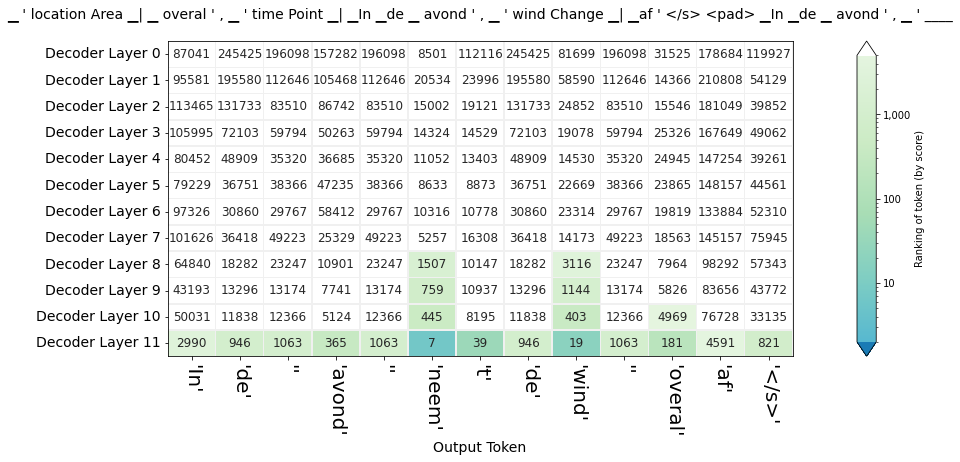

In [ ]:
output.rankings_watch(watch=[563, 269, 259, 48571, 259, 25686, 270, 269, 25720, 259, 217529, 643, 1], position=37)

In [ ]:
output.saliency()

AttributeError: ignored

### BertViz Initial Review

In [ ]:
from bertviz import model_view
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM

model_path = '/content/drive/MyDrive/MscThesis/Models/google_mt5-base/'

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path, output_attentions=True)

'victimAge_Group | minor', 'victimGender | female', 'victimRace | Hispanic'

In [ ]:
encoder_input_ids = tokenizer("['locationArea | overal', 'windSpeedBft | 6-7']", return_tensors="pt", add_special_tokens=True).input_ids

with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer("De wind is overal 6-7 Bft.", return_tensors="pt", add_special_tokens=True).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3547: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  "`as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your "


In [ ]:
from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
encoder_input_ids = tokenizer("['locationArea | overal', 'timePoint | In de avond', 'windChange | af']", return_tensors="pt", add_special_tokens=True).input_ids

with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer("In de avond neemt de wind overal af.", return_tensors="pt", add_special_tokens=True).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

In [ ]:
from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

In [ ]:
from bertviz import head_view
head_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

### Testing

In [ ]:
from ast import literal_eval
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, pipeline,  EarlyStoppingCallback, DataCollatorForSeq2Seq, Trainer
from transformers import MT5ForConditionalGeneration, T5Tokenizer, T5ForConditionalGeneration
import datasets
import evaluate
import accelerate

In [ ]:
def preprocess_model(model_name):
    """
    Setup the model and tokenizer for preprocessing. This will be a pre-trained model collected from huggingface
    """

    #with deepspeed.zero.Init():
      #config = T5Config.from_pretrained("t5-small")
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # model = MT5ForConditionalGeneration.from_pretrained(model_name)
    # tokenizer = MT5TokenizerFast.from_pretrained(model_name)

    print('LOGGING: preprocess_model DONE \n')
    return model, tokenizer


def load_CACAPO_data():
    """
    This function retrieves the csv files and creates a dataset
    """
    print('LOGGING: load_CACAPO_data DONE \n')

    return datasets.load_dataset("/content/drive/MyDrive/MscThesis/Data/Cleaned_data", data_files={"train": "Train.csv", "dev": "Dev.csv", "test": "Test.csv"})


def preprocess_data(data):
    """
    Tokenize the data
    """
    max_length = 256
    RDFs = data["input"]
    texts = data["output"]

    ## When converting a pandas df to csv (used for loading dataset), a list of lists can transform to a long string
    ## Here we convert it back with literal_eval

    for rdf_iteration, rdf in enumerate(RDFs):
        RDFs[rdf_iteration] = literal_eval(rdf)
        print(RDFs[rdf_iteration])

    #This creates a dataset object of model_inputs{input_ids, attention_mask}
    model_inputs = tokenizer(RDFs, truncation=True, padding='max_length', return_tensors='pt',  max_length=max_length, is_split_into_words=True)
    
    # specially for seq2seq tokenizer, "Temporarily sets the tokenizer for encoding the targets. Useful for tokenizer associated to sequence-to-sequence models that need a slightly different processing for the labels."
    with tokenizer.as_target_tokenizer():
        target_texts = tokenizer(texts, padding='max_length', truncation=True, return_tensors='pt',  max_length=max_length).input_ids

    #This adds the tokenized target texts as a new column in the dataset object, thus becoming model_inputs{input_ids, attention_mask, labels}
    model_inputs["labels"] = target_texts

    return model_inputs



def transform_datasets(dataset):
    """
    After loading in and creating the initial dataset, the text data is transformed, by tokenizing the input and output texts. The initial dataset is also split into train,val,test for training use.
    NOTE That the test set will not be preprocessed here yet, this will be done in a different function
    """

    train_ds = dataset["train"]
    val_ds = dataset["dev"]
    test_ds = dataset["test"]

    # to use the actual articles for evaluation
    true_articles_test = test_ds['output']
    # The Parent Metric requires the original RDFs
    test_rdf_input = test_ds['input']


    ## Process the data in batches
    train_ds = train_ds.map(preprocess_data, batched=True, remove_columns=dataset["train"].column_names)
    val_ds = val_ds.map(preprocess_data, batched=True, remove_columns=dataset["dev"].column_names)
    test_ds = test_ds.map(preprocess_data, batched=True, remove_columns=dataset["test"].column_names)

    # transform the datasets into torch sensors, as the model will expect this format
    train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels']) #, device="cuda")
    val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels']) #, device="cuda")
    test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'] , device="cuda")

    print('LOGGING: transform_datasets DONE \n')

    return train_ds, val_ds, test_ds, true_articles_test, test_rdf_input

def fine_tune_model(model_name):

    model, tokenizer = preprocess_model(model_name)
    #print(tokenizer)
    
    ### retrieve the unprocessed data from the csv files
    entire_dataset = load_CACAPO_data()
    
    # ## process the dataset and split it into its natural train, val, test split
    train_ds, val_ds, test_ds, true_articles_test, test_rdf_inputs = transform_datasets(entire_dataset)


In [ ]:
fine_tune_model('google/mt5-base')

### Histograms

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval

#### Worst 200 comparison between contrastive and beam

In [ ]:
#Load in files

mt5_beam_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/Round 2/Beam_mt5_worst_200_1_generations.xlsx')
t5_beam_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/Round 2/Beam_t5_dutch_worst_200_1_generations.xlsx')

mt5_contrastive_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/Round 2/Contrastive_mt5_dutch_worst_200s.xlsx')
t5_contrastive_worst_df = pd.read_excel(f'/content/drive/MyDrive/MscThesis/Post_manual_eval/Round 2/Contrastive_t5_dutch_worst_200.xlsx')


In [ ]:
# create totals for easy barplots

mt5_beam_sums = mt5_beam_worst_df.select_dtypes(pd.np.number).sum().rename('total')
t5_beam_sums = t5_beam_worst_df.select_dtypes(pd.np.number).sum().rename('total')
mt5_contrastive_sums = mt5_contrastive_worst_df.select_dtypes(pd.np.number).sum().rename('total')
t5_contrastive_sums = t5_contrastive_worst_df.select_dtypes(pd.np.number).sum().rename('total')



# append sums to the data frame
mt5_beam_worst_df = mt5_beam_worst_df.append(mt5_beam_sums)
t5_beam_worst_df = t5_beam_worst_df.append(t5_beam_sums)
mt5_contrastive_worst_df = mt5_contrastive_worst_df.append(mt5_contrastive_sums)
t5_contrastive_worst_df = t5_contrastive_worst_df.append(t5_contrastive_sums)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


Text(0, 0.5, 'Total number')

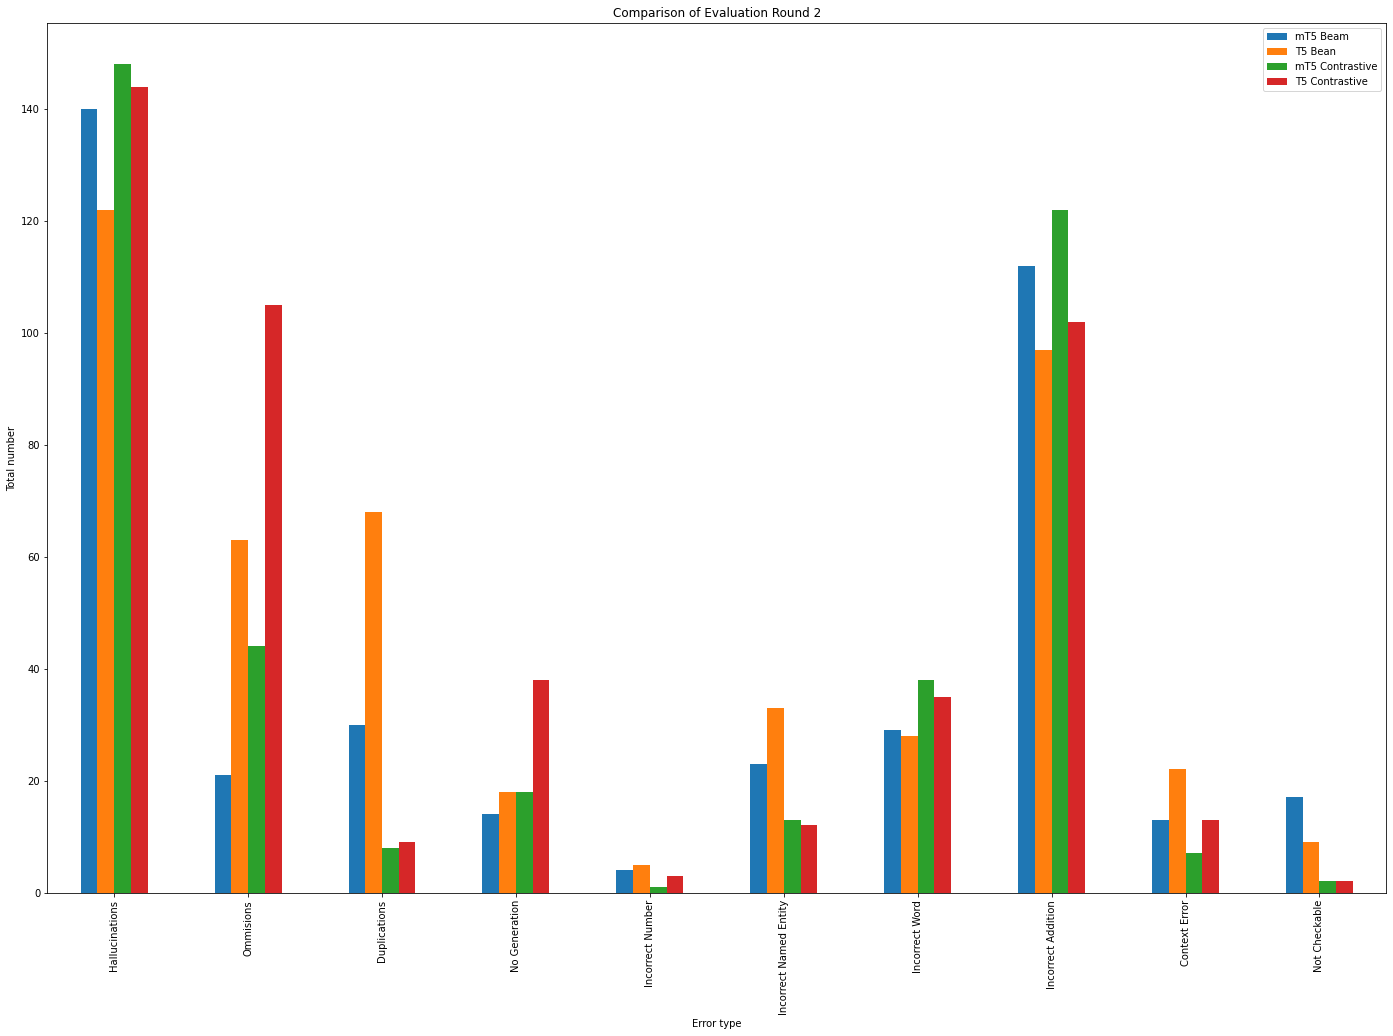

In [ ]:
### ----> Need to replace the pies with specific column values (e.g. df[Total])
plotdata = pd.DataFrame({
    "mT5 Beam":[mt5_beam_worst_df.loc['total']['Hallucinations'], mt5_beam_worst_df.loc['total']['Ommisions'], mt5_beam_worst_df.loc['total']['Duplications'], mt5_beam_worst_df.loc['total']['No Generation'], mt5_beam_worst_df.loc['total']['Incorrect Number'],
                mt5_beam_worst_df.loc['total']['Incorrect Named Entity'],mt5_beam_worst_df.loc['total']['Incorrect Word'],mt5_beam_worst_df.loc['total']['Incorrect Addition'],mt5_beam_worst_df.loc['total']['Context Error'],mt5_beam_worst_df.loc['total']['Not Checkable']],

    "T5 Bean":[t5_beam_worst_df.loc['total']['Hallucinations'], t5_beam_worst_df.loc['total']['Ommisions'], t5_beam_worst_df.loc['total']['Duplications'], t5_beam_worst_df.loc['total']['No Generation'], t5_beam_worst_df.loc['total']['Incorrect Number'],
                t5_beam_worst_df.loc['total']['Incorrect Named Entity'],t5_beam_worst_df.loc['total']['Incorrect Word'],t5_beam_worst_df.loc['total']['Incorrect Addition'],t5_beam_worst_df.loc['total']['Context Error'],t5_beam_worst_df.loc['total']['Not Checkable']],

    "mT5 Contrastive":[mt5_contrastive_worst_df.loc['total']['Hallucinations'], mt5_contrastive_worst_df.loc['total']['Ommisions'], mt5_contrastive_worst_df.loc['total']['Duplications'], mt5_contrastive_worst_df.loc['total']['No Generation'], mt5_contrastive_worst_df.loc['total']['Incorrect Number'],
                mt5_contrastive_worst_df.loc['total']['Incorrect Named Entity'],mt5_contrastive_worst_df.loc['total']['Incorrect Word'],mt5_contrastive_worst_df.loc['total']['Incorrect Addition'],mt5_contrastive_worst_df.loc['total']['Context Error'],mt5_contrastive_worst_df.loc['total']['Not Checkable']],

    "T5 Contrastive":[t5_contrastive_worst_df.loc['total']['Hallucinations'], t5_contrastive_worst_df.loc['total']['Ommisions'], t5_contrastive_worst_df.loc['total']['Duplications'], t5_contrastive_worst_df.loc['total']['No Generation'], t5_contrastive_worst_df.loc['total']['Incorrect Number'],
                t5_contrastive_worst_df.loc['total']['Incorrect Named Entity'],t5_contrastive_worst_df.loc['total']['Incorrect Word'],t5_contrastive_worst_df.loc['total']['Incorrect Addition'],t5_contrastive_worst_df.loc['total']['Context Error'],t5_contrastive_worst_df.loc['total']['Not Checkable']]
    }, 
    index=["Hallucinations", "Ommisions", "Duplications", "No Generation", "Incorrect Number", "Incorrect Named Entity", "Incorrect Word", "Incorrect Addition", "Context Error", "Not Checkable"]
)
plotdata.plot(kind="bar", figsize=(24,16))
#plotdata.figure(figsize=(24,16))
plt.title("Comparison of Evaluation Round 2")
plt.xlabel("Error type")
plt.ylabel("Total number")

Text(0.5, 0, 'Total number')

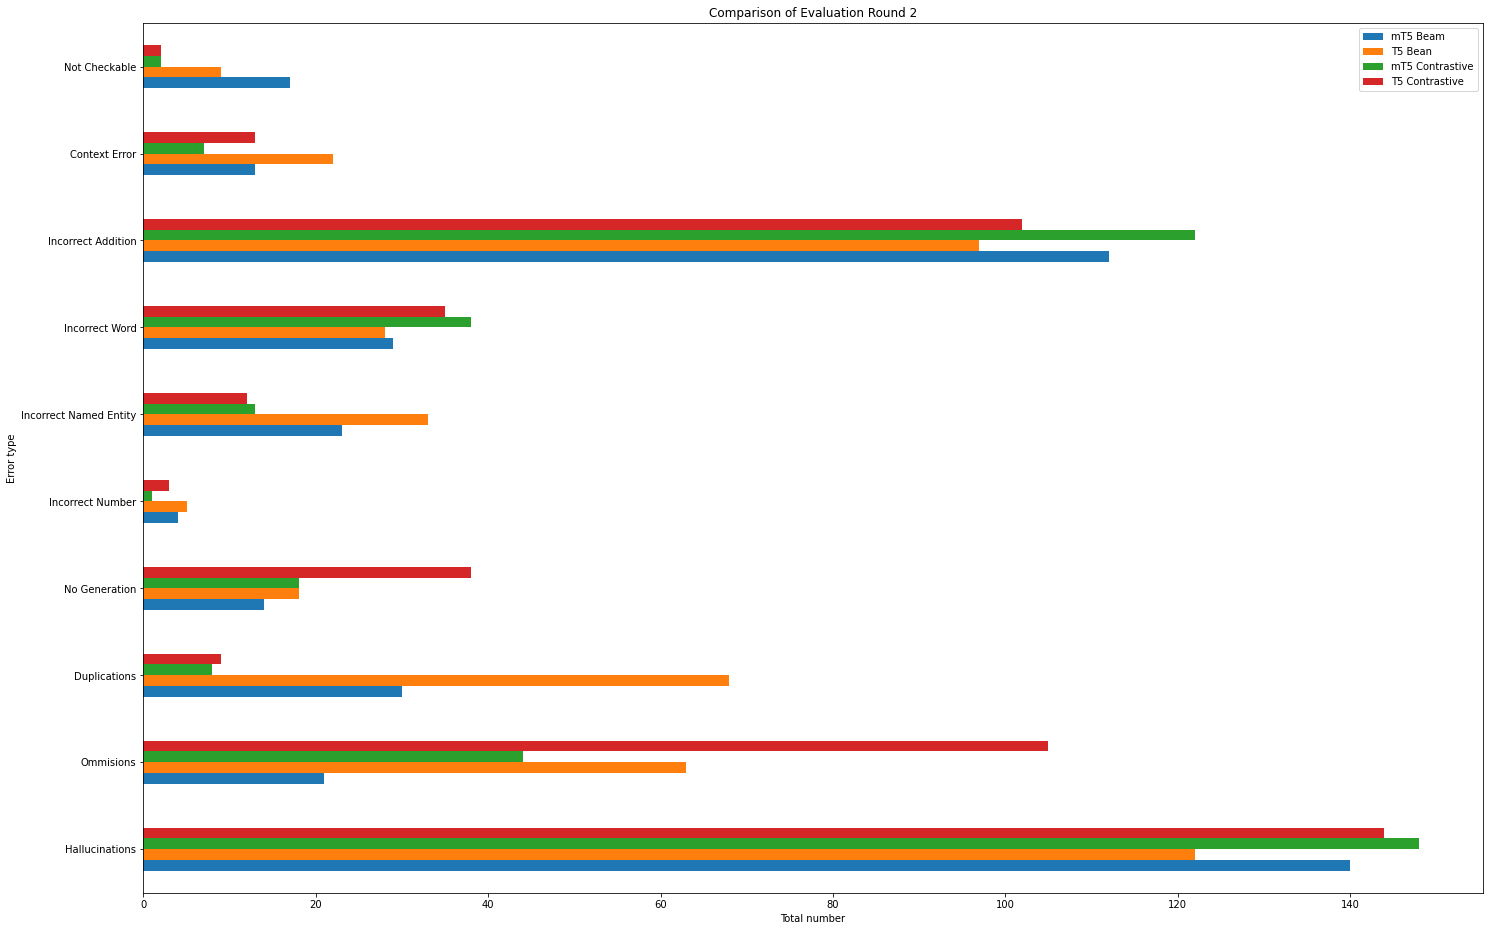

In [ ]:
### ----> Need to replace the pies with specific column values (e.g. df[Total])
plotdata = pd.DataFrame({
    "mT5 Beam":[mt5_beam_worst_df.loc['total']['Hallucinations'], mt5_beam_worst_df.loc['total']['Ommisions'], mt5_beam_worst_df.loc['total']['Duplications'], mt5_beam_worst_df.loc['total']['No Generation'], mt5_beam_worst_df.loc['total']['Incorrect Number'],
                mt5_beam_worst_df.loc['total']['Incorrect Named Entity'],mt5_beam_worst_df.loc['total']['Incorrect Word'],mt5_beam_worst_df.loc['total']['Incorrect Addition'],mt5_beam_worst_df.loc['total']['Context Error'],mt5_beam_worst_df.loc['total']['Not Checkable']],

    "T5 Bean":[t5_beam_worst_df.loc['total']['Hallucinations'], t5_beam_worst_df.loc['total']['Ommisions'], t5_beam_worst_df.loc['total']['Duplications'], t5_beam_worst_df.loc['total']['No Generation'], t5_beam_worst_df.loc['total']['Incorrect Number'],
                t5_beam_worst_df.loc['total']['Incorrect Named Entity'],t5_beam_worst_df.loc['total']['Incorrect Word'],t5_beam_worst_df.loc['total']['Incorrect Addition'],t5_beam_worst_df.loc['total']['Context Error'],t5_beam_worst_df.loc['total']['Not Checkable']],

    "mT5 Contrastive":[mt5_contrastive_worst_df.loc['total']['Hallucinations'], mt5_contrastive_worst_df.loc['total']['Ommisions'], mt5_contrastive_worst_df.loc['total']['Duplications'], mt5_contrastive_worst_df.loc['total']['No Generation'], mt5_contrastive_worst_df.loc['total']['Incorrect Number'],
                mt5_contrastive_worst_df.loc['total']['Incorrect Named Entity'],mt5_contrastive_worst_df.loc['total']['Incorrect Word'],mt5_contrastive_worst_df.loc['total']['Incorrect Addition'],mt5_contrastive_worst_df.loc['total']['Context Error'],mt5_contrastive_worst_df.loc['total']['Not Checkable']],

    "T5 Contrastive":[t5_contrastive_worst_df.loc['total']['Hallucinations'], t5_contrastive_worst_df.loc['total']['Ommisions'], t5_contrastive_worst_df.loc['total']['Duplications'], t5_contrastive_worst_df.loc['total']['No Generation'], t5_contrastive_worst_df.loc['total']['Incorrect Number'],
                t5_contrastive_worst_df.loc['total']['Incorrect Named Entity'],t5_contrastive_worst_df.loc['total']['Incorrect Word'],t5_contrastive_worst_df.loc['total']['Incorrect Addition'],t5_contrastive_worst_df.loc['total']['Context Error'],t5_contrastive_worst_df.loc['total']['Not Checkable']]
    }, 
    index=["Hallucinations", "Ommisions", "Duplications", "No Generation", "Incorrect Number", "Incorrect Named Entity", "Incorrect Word", "Incorrect Addition", "Context Error", "Not Checkable"]
)
plotdata.plot(kind="barh", figsize=(24,16))
#plotdata.figure(figsize=(24,16))
plt.title("Comparison of Evaluation Round 2")
plt.ylabel("Error type")
plt.xlabel("Total number")

#### Distribution of Bartscores

In [ ]:
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/T5d_contrastive.pickle', 'rb')
# dump information to that file
t5_contrastive_df = pickle.load(file)
# close the file
file.close()


# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/mT5_contrastive.pickle', 'rb')
# dump information to that file
mt5_contrastive_df = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/T5d_all_beamSearch_one_generations..pickle', 'rb')
# dump information to that file
dutch_df = pickle.load(file)
# close the file
file.close()

# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/mT5_all_beamSearch_one_generations..pickle', 'rb')
# dump information to that file
mt5_df = pickle.load(file)
# close the file
file.close()


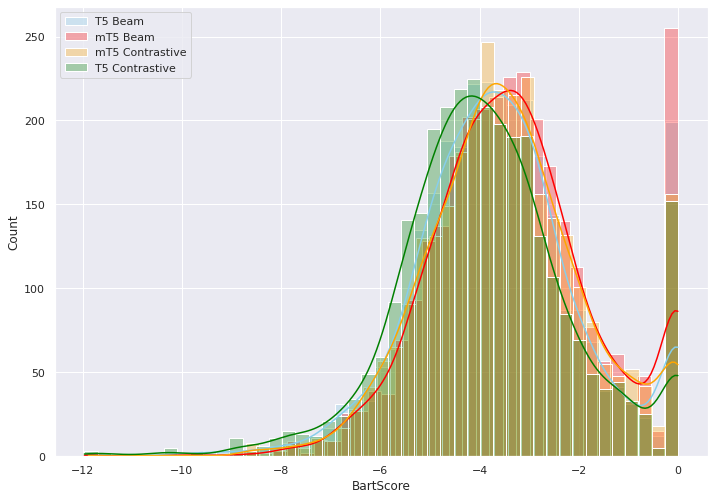

In [ ]:
# libraries & dataset

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.histplot(data=dutch_df["BartScore"], color="skyblue", label="T5 Beam", kde=True, alpha=0.3)
sns.histplot(data=mt5_df["BartScore"], color="red", label="mT5 Beam", kde=True, alpha=0.3)
sns.histplot(data=mt5_contrastive_df["BartScore"], color="orange", label="mT5 Contrastive", kde=True, alpha=0.3)
sns.histplot(data=t5_contrastive_df["BartScore"], color="green", label="T5 Contrastive", kde=True, alpha=0.3)

plt.legend() 
plt.show()

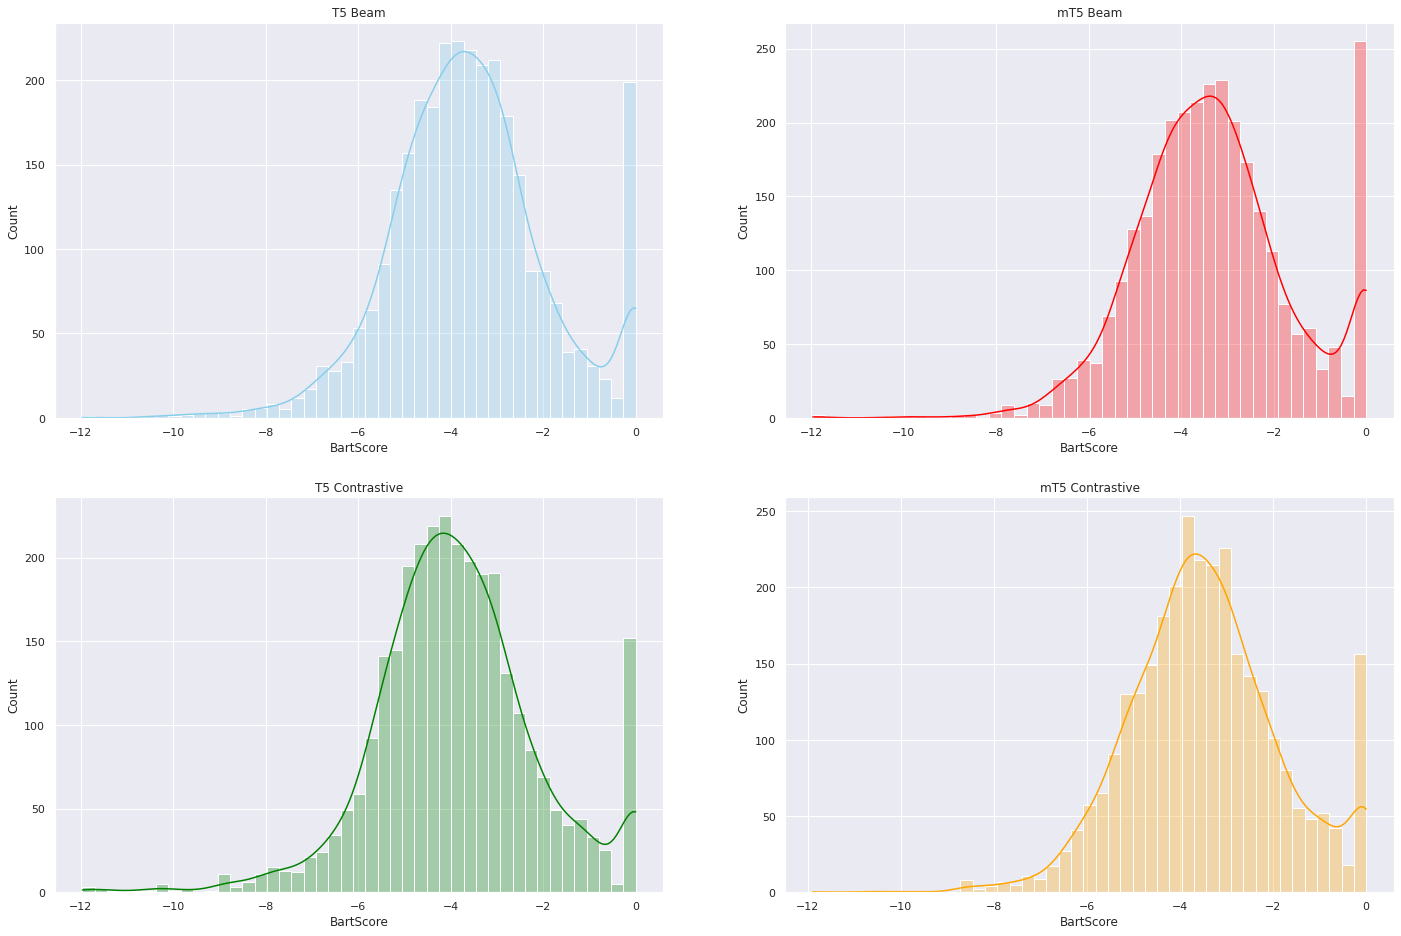

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(24, 16))
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# plt.rcParams["figure.figsize"] = (24,16)

sns.histplot(data=dutch_df["BartScore"], color="skyblue",  label="T5 Beam", kde=True, alpha=0.3, ax=axs[0, 0]).set_title('T5 Beam')
sns.histplot(data=mt5_df["BartScore"], color="red", label="mT5 Beam", kde=True, alpha=0.3, ax=axs[0, 1]).set_title('mT5 Beam')
sns.histplot(data=t5_contrastive_df["BartScore"], color="green", label="T5 Contrastive", kde=True, alpha=0.3, ax=axs[1, 0]).set_title('T5 Contrastive')
sns.histplot(data=mt5_contrastive_df["BartScore"], color="orange", label="mT5 Contrastive", kde=True, alpha=0.3, ax=axs[1, 1]).set_title('mT5 Contrastive')


plt.show()

In [ ]:
def get_RDF_count(dataframe):
  dataframe['RDF'] = dataframe['RDF'].apply(lambda x: literal_eval(x))
  dataframe['RDF_Count'] = dataframe['RDF'].apply(lambda x: len(x))
  return dataframe


dutch_df = get_RDF_count(dutch_df)
mt5_df = get_RDF_count(mt5_df)
t5_contrastive_df = get_RDF_count(t5_contrastive_df)
mt5_contrastive_df = get_RDF_count(mt5_contrastive_df)

All data

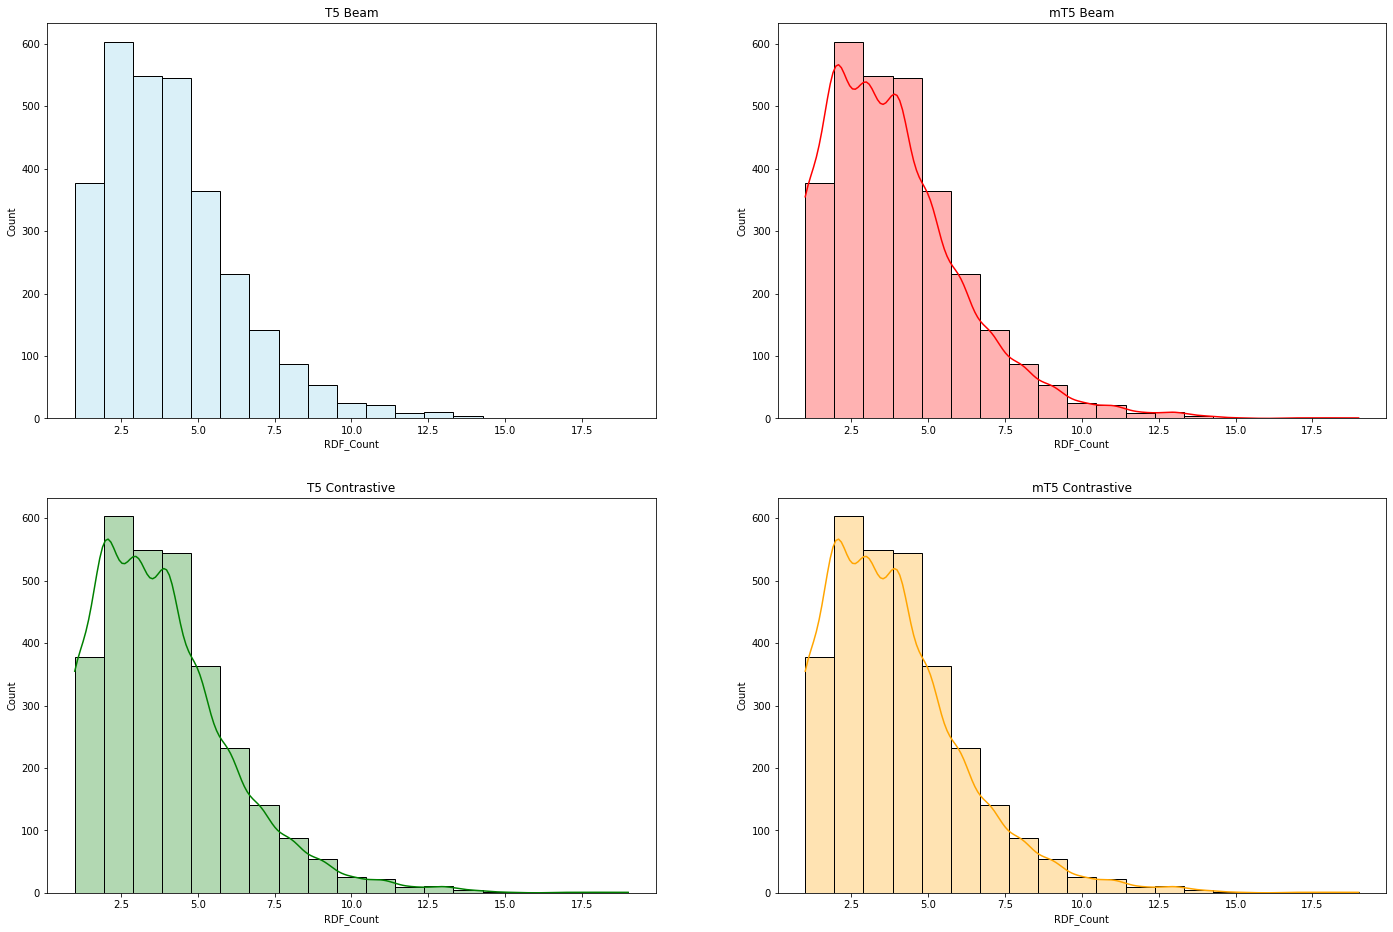

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(24, 16))
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# plt.rcParams["figure.figsize"] = (24,16)

sns.histplot(data=dutch_df["RDF_Count"], color="skyblue", bins=19,  label="T5 Beam", kde=True, alpha=0.3, ax=axs[0, 0]).set_title('T5 Beam')
sns.histplot(data=mt5_df["RDF_Count"], color="red", bins=19, label="mT5 Beam", kde=True, alpha=0.3, ax=axs[0, 1]).set_title('mT5 Beam')
sns.histplot(data=t5_contrastive_df["RDF_Count"], bins=19, color="green", label="T5 Contrastive", kde=True, alpha=0.3, ax=axs[1, 0]).set_title('T5 Contrastive')
sns.histplot(data=mt5_contrastive_df["RDF_Count"], bins=19, color="orange", label="mT5 Contrastive", kde=True, alpha=0.3, ax=axs[1, 1]).set_title('mT5 Contrastive')

plt.show()

Worst 200 splits


[ 1  2  4  5  8  6 10 12  3  7  9 13]
[1 3 2 4 8 5 6 7]
[ 1  2  6 10  4  3  8 12  5  7 14]
[1 2 4 3 5 8 6 9 7]


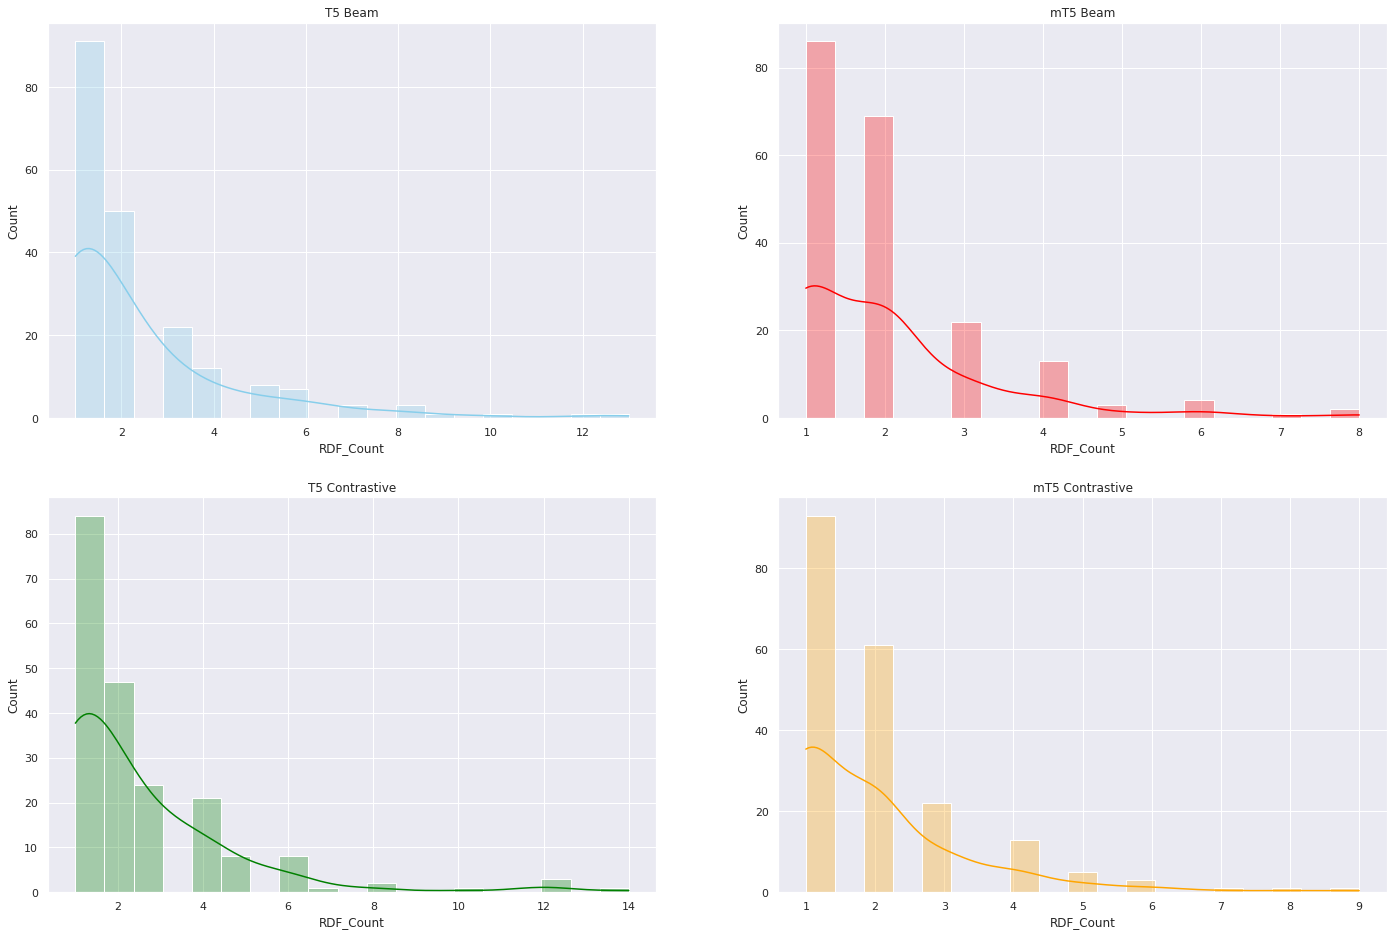

In [ ]:
T5_beam_copy = t5_beam_worst_df.copy(deep=True)
mT5_beam_copy = mt5_beam_worst_df.copy(deep=True)
T5_contrastive_copy = t5_contrastive_worst_df.copy(deep=True)
mT5_contrastive_copy = mt5_contrastive_worst_df.copy(deep=True)

# Get the RDF counts
T5_beam_extended = get_RDF_count(T5_beam_copy)
mT5_beam_extended = get_RDF_count(mT5_beam_copy)
T5_contrastive_extended = get_RDF_count(T5_contrastive_copy)
mT5_contrastive_extended = get_RDF_count(mT5_contrastive_copy)

fig, axs = plt.subplots(2, 2, figsize=(24, 16))
# sns.set(rc={'figure.figsize':(11.7,8.27)})
# plt.rcParams["figure.figsize"] = (24,16)

sns.histplot(data=T5_beam_extended["RDF_Count"], color="skyblue", bins=19,  label="T5 Beam", kde=True, alpha=0.3, ax=axs[0, 0]).set_title('T5 Beam')
sns.histplot(data=mT5_beam_extended["RDF_Count"], color="red", bins=19, label="mT5 Beam", kde=True, alpha=0.3, ax=axs[0, 1]).set_title('mT5 Beam')
sns.histplot(data=T5_contrastive_extended["RDF_Count"], bins=19, color="green", label="T5 Contrastive", kde=True, alpha=0.3, ax=axs[1, 0]).set_title('T5 Contrastive')
sns.histplot(data=mT5_contrastive_extended["RDF_Count"], bins=19, color="orange", label="mT5 Contrastive", kde=True, alpha=0.3, ax=axs[1, 1]).set_title('mT5 Contrastive')

plt.show()

### Continue per rdf count
Now we weant to check if the performance dips with certain rdf counts. For example, the fewer rdfs, the more mistakes are expected


In [ ]:
def get_RDF_count(dataframe):
  dataframe['RDF'] = dataframe['RDF'].apply(lambda x: literal_eval(x))
  dataframe['RDF_Count'] = dataframe['RDF'].apply(lambda x: len(x))

  print(dataframe['RDF_Count'].unique())
  return dataframe

def get_sum_eval(dataframe):
  dataframe_sums = dataframe.select_dtypes(pd.np.number).sum().rename('total')
  dataframe = dataframe.append(dataframe_sums)
  return dataframe

def filter_df_on_rdf_count(dataframe, count):
  return dataframe[(dataframe['RDF_Count'] == count)]
 

def plot_bar_chart(T5_beam, mT5_beam, T5_contrastive, mT5_contrastive, plot_title):
  plotdata = pd.DataFrame({
      
  "T5 Bean":[ len(T5_beam) ,T5_beam.loc['total']['Hallucinations'], T5_beam.loc['total']['Ommisions'], T5_beam.loc['total']['Duplications'], T5_beam.loc['total']['No Generation'], T5_beam.loc['total']['Incorrect Number'],
              T5_beam.loc['total']['Incorrect Named Entity'],T5_beam.loc['total']['Incorrect Word'],T5_beam.loc['total']['Incorrect Addition'],T5_beam.loc['total']['Context Error'],T5_beam.loc['total']['Not Checkable']],
    
  "mT5 Beam":[ len(mT5_beam) ,mT5_beam.loc['total']['Hallucinations'], mT5_beam.loc['total']['Ommisions'], mT5_beam.loc['total']['Duplications'], mT5_beam.loc['total']['No Generation'], mT5_beam.loc['total']['Incorrect Number'],
              mT5_beam.loc['total']['Incorrect Named Entity'],mT5_beam.loc['total']['Incorrect Word'],mT5_beam.loc['total']['Incorrect Addition'],mT5_beam.loc['total']['Context Error'],mT5_beam.loc['total']['Not Checkable']],

  "T5 Contrastive":[ len(T5_contrastive) ,T5_contrastive.loc['total']['Hallucinations'], T5_contrastive.loc['total']['Ommisions'], T5_contrastive.loc['total']['Duplications'], T5_contrastive.loc['total']['No Generation'], T5_contrastive.loc['total']['Incorrect Number'],
              T5_contrastive.loc['total']['Incorrect Named Entity'],T5_contrastive.loc['total']['Incorrect Word'],T5_contrastive.loc['total']['Incorrect Addition'],T5_contrastive.loc['total']['Context Error'],T5_contrastive.loc['total']['Not Checkable']],
  
  "mT5 Contrastive":[ len(mT5_contrastive) ,mT5_contrastive.loc['total']['Hallucinations'], mT5_contrastive.loc['total']['Ommisions'], mT5_contrastive.loc['total']['Duplications'], mT5_contrastive.loc['total']['No Generation'], mT5_contrastive.loc['total']['Incorrect Number'],
              mT5_contrastive.loc['total']['Incorrect Named Entity'],mT5_contrastive.loc['total']['Incorrect Word'],mT5_contrastive.loc['total']['Incorrect Addition'],mT5_contrastive.loc['total']['Context Error'],mT5_contrastive.loc['total']['Not Checkable']]
  }, 
  index=["Total Length Dataframe", "Hallucinations", "Ommisions", "Duplications", "No Generation", "Incorrect Number", "Incorrect Named Entity", "Incorrect Word", "Incorrect Addition", "Context Error", "Not Checkable"]
  )
  plotdata.plot(kind="barh", figsize=(24,16), grid=True)
  #plotdata.figure(figsize=(24,16))
  plt.title(plot_title)
  plt.ylabel("Error type")
  plt.xlabel("Total number")


def run_plot(T5_beam, mT5_beam, T5_contrastive, mT5_contrastive, plot_title, count=None):
  #Create copies so that this plot function can be called multiple times (Literal_eval only works once on a string)
  T5_beam_copy = T5_beam.copy(deep=True)
  mT5_beam_copy = mT5_beam.copy(deep=True)
  T5_contrastive_copy = T5_contrastive.copy(deep=True)
  mT5_contrastive_copy = mT5_contrastive.copy(deep=True)

  # Get the RDF counts
  T5_beam_extended = get_RDF_count(T5_beam_copy)
  mT5_beam_extended = get_RDF_count(mT5_beam_copy)
  T5_contrastive_extended = get_RDF_count(T5_contrastive_copy)
  mT5_contrastive_extended = get_RDF_count(mT5_contrastive_copy)

  if count != None:
    T5_beam_extended = filter_df_on_rdf_count(T5_beam_extended, count)
    mT5_beam_extended = filter_df_on_rdf_count(mT5_beam_extended, count)
    T5_contrastive_extended = filter_df_on_rdf_count(T5_contrastive_extended, count)
    mT5_contrastive_extended = filter_df_on_rdf_count(mT5_contrastive_extended, count)

  # else:
  #   plot_rdf_count_distribution(T5_beam_extended, mT5_beam_extended, T5_contrastive_extended, mT5_contrastive_extended)
  #   print('\n\n')


  # Get the sums for each of the manually evaluated columns
  t5_beam_summed = get_sum_eval(T5_beam_extended)
  mt5_beam_summed = get_sum_eval(mT5_beam_extended)
  t5_contrastive_summed = get_sum_eval(T5_contrastive_extended)
  mt5_contrastive_summed = get_sum_eval(mT5_contrastive_extended)

  #plot the data
  plot_bar_chart(t5_beam_summed, mt5_beam_summed, t5_contrastive_summed, mt5_contrastive_summed, plot_title)


[ 1  2  4  5  8  6 10 12  3  7  9 13]
[1 3 2 4 8 5 6 7]
[ 1  2  6 10  4  3  8 12  5  7 14]
[1 2 4 3 5 8 6 9 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


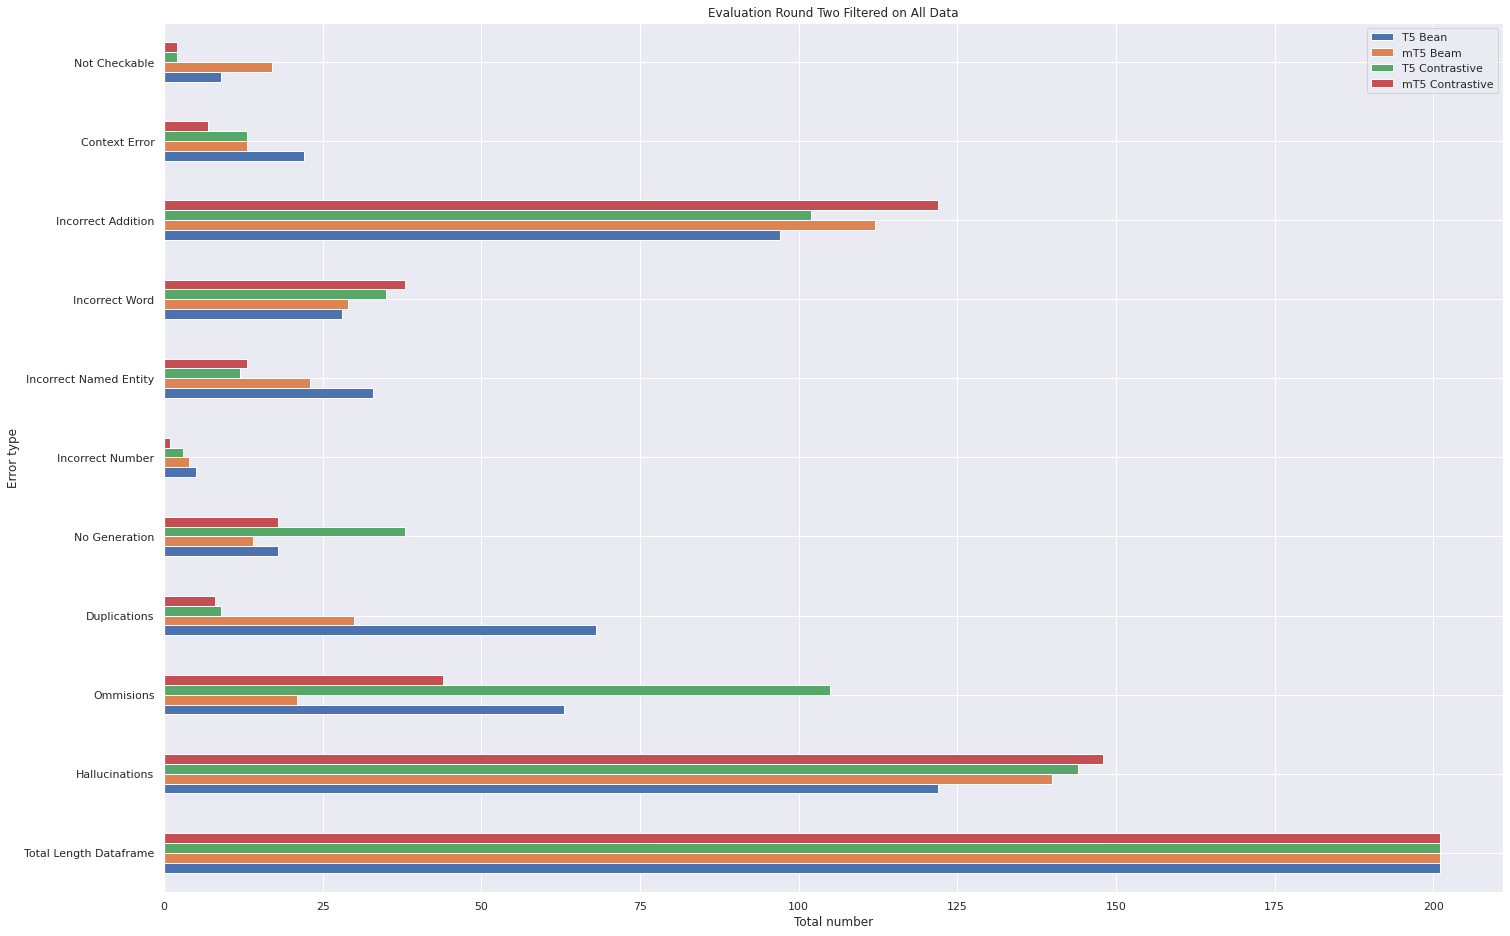

In [ ]:
run_plot(t5_beam_worst_df, mt5_beam_worst_df, t5_contrastive_worst_df, mt5_contrastive_worst_df, "Evaluation Round Two Filtered on All Data")

[ 1  2  4  5  8  6 10 12  3  7  9 13]
[1 3 2 4 8 5 6 7]
[ 1  2  6 10  4  3  8 12  5  7 14]
[1 2 4 3 5 8 6 9 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


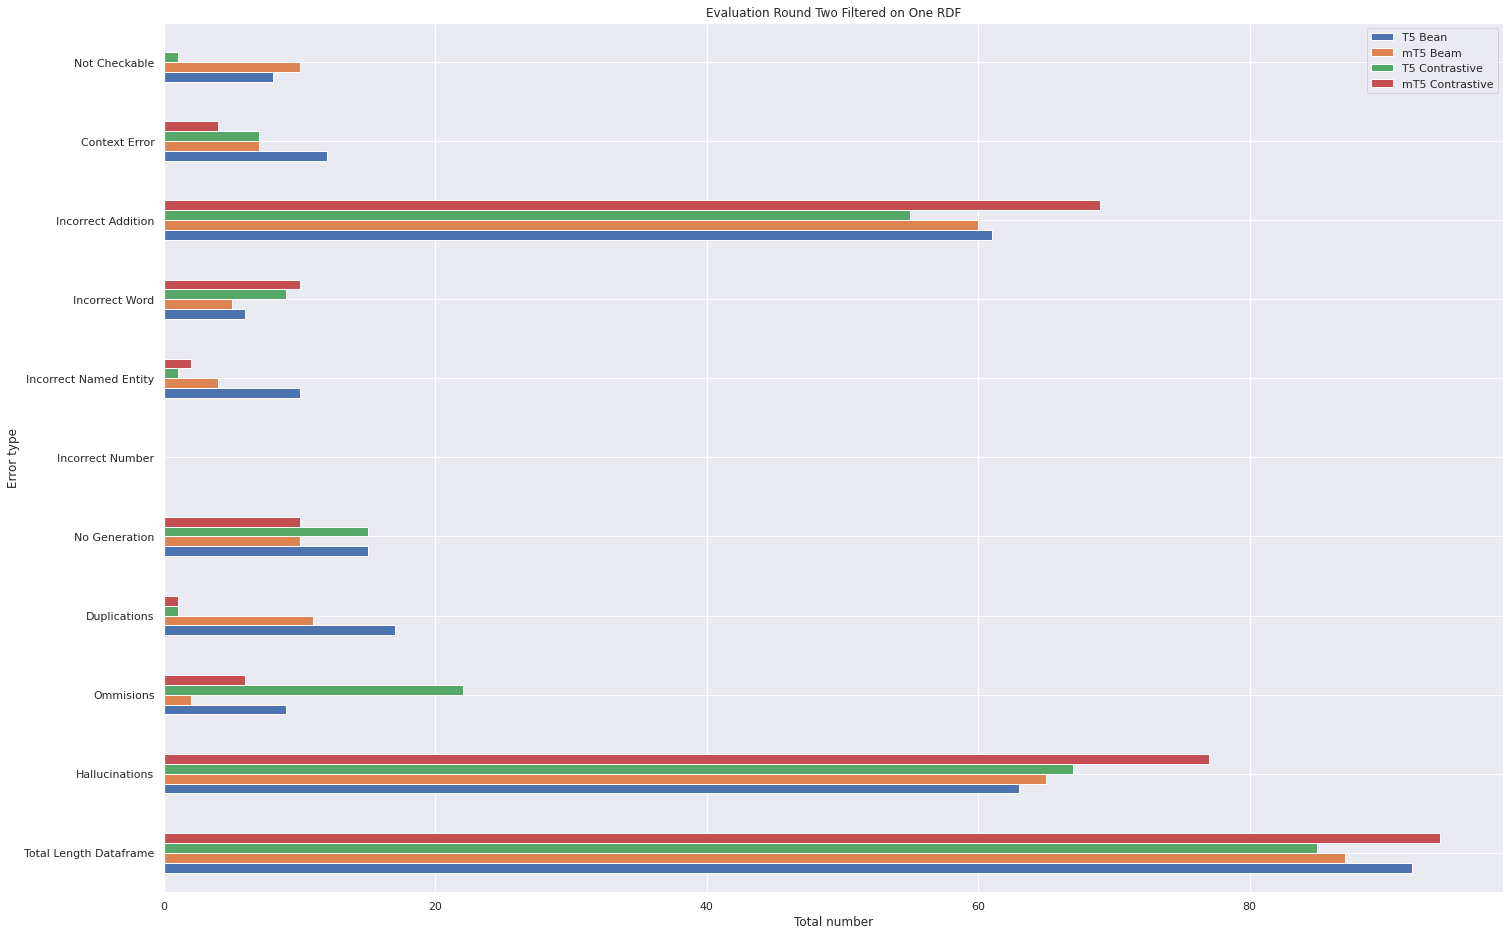

In [ ]:
run_plot(t5_beam_worst_df, mt5_beam_worst_df, t5_contrastive_worst_df, mt5_contrastive_worst_df, "Evaluation Round Two Filtered on One RDF Input", count=1)

[ 1  2  4  5  8  6 10 12  3  7  9 13]
[1 3 2 4 8 5 6 7]
[ 1  2  6 10  4  3  8 12  5  7 14]
[1 2 4 3 5 8 6 9 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


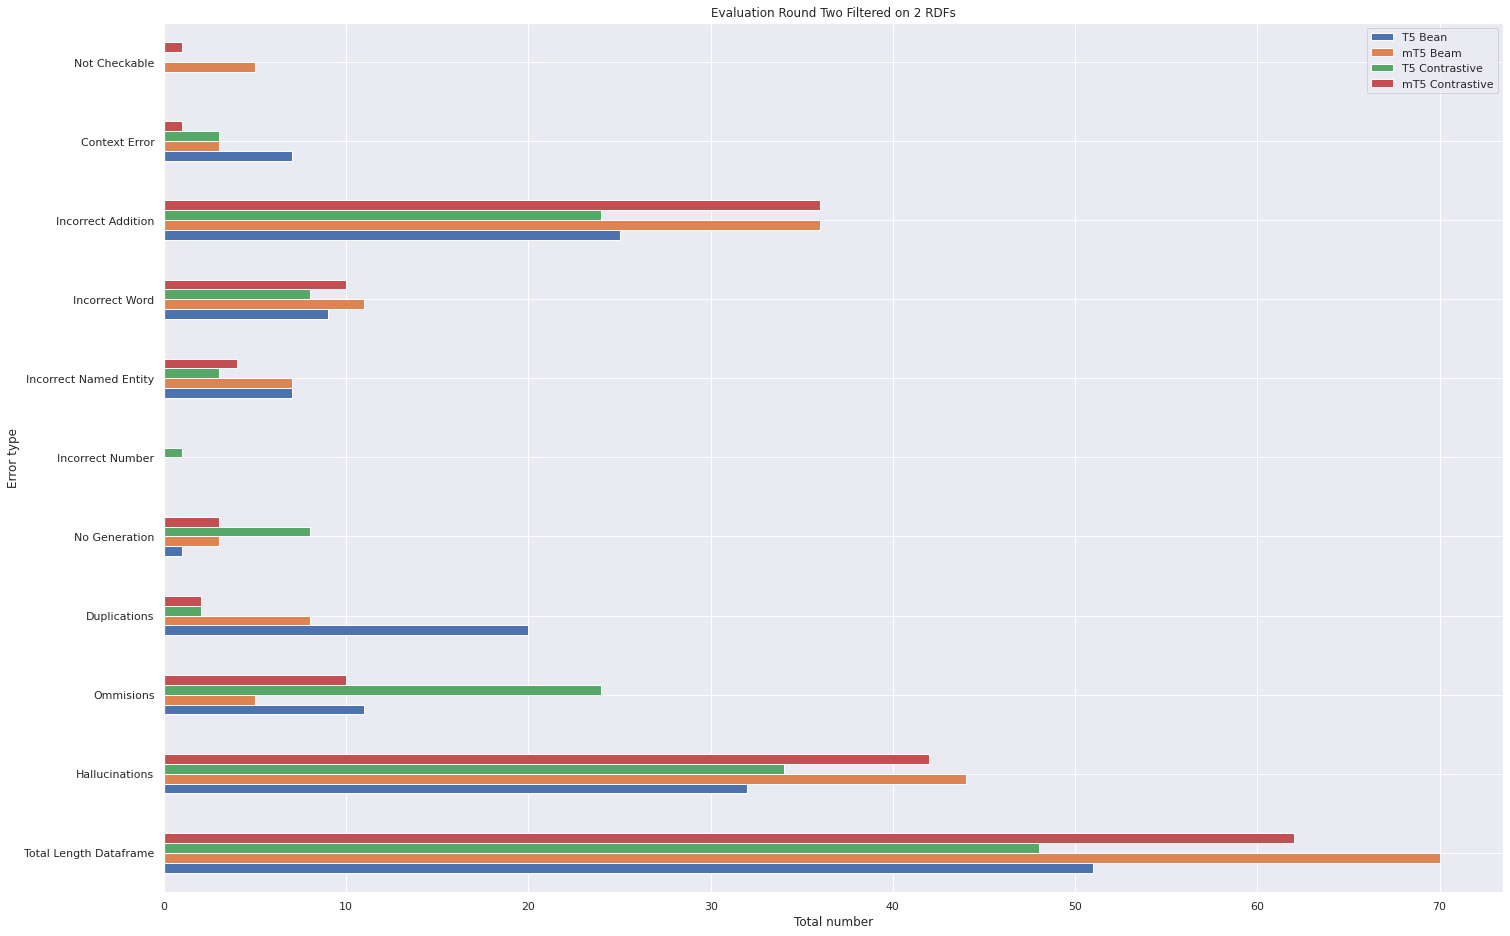

In [ ]:
run_plot(t5_beam_worst_df, mt5_beam_worst_df, t5_contrastive_worst_df, mt5_contrastive_worst_df, "Evaluation Round Two Filtered on 2 RDFs Input", count=2)

[ 1  2  4  5  8  6 10 12  3  7  9 13]
[1 3 2 4 8 5 6 7]
[ 1  2  6 10  4  3  8 12  5  7 14]
[1 2 4 3 5 8 6 9 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


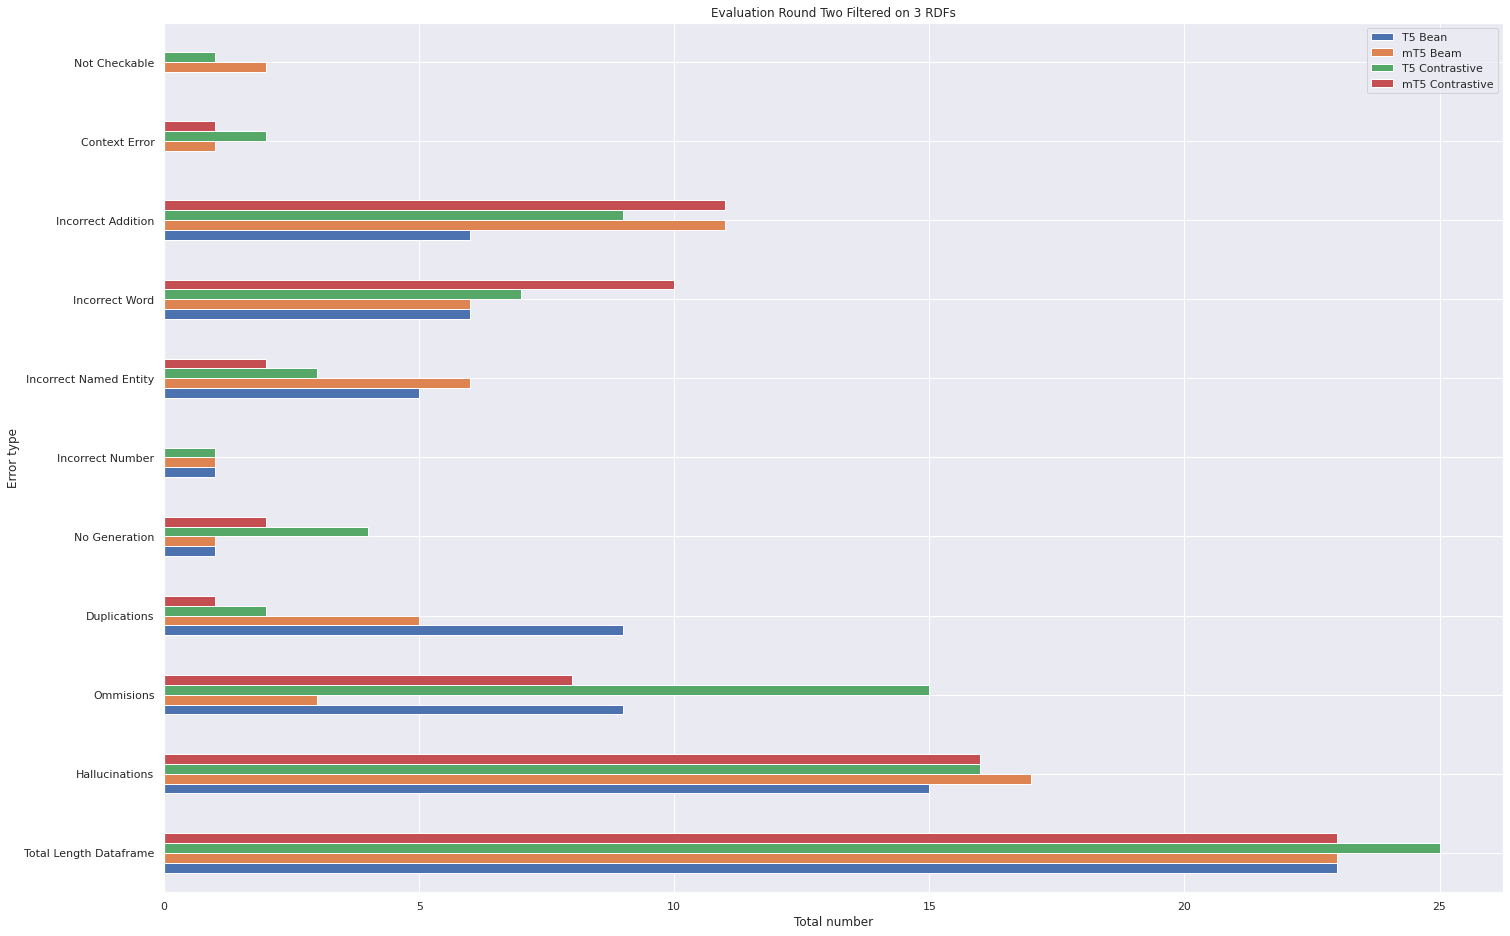

In [ ]:
run_plot(t5_beam_worst_df, mt5_beam_worst_df, t5_contrastive_worst_df, mt5_contrastive_worst_df, "Evaluation Round Two Filtered on 3 RDFs Input", count=3)

[ 1  2  4  5  8  6 10 12  3  7  9 13]
[1 3 2 4 8 5 6 7]
[ 1  2  6 10  4  3  8 12  5  7 14]
[1 2 4 3 5 8 6 9 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


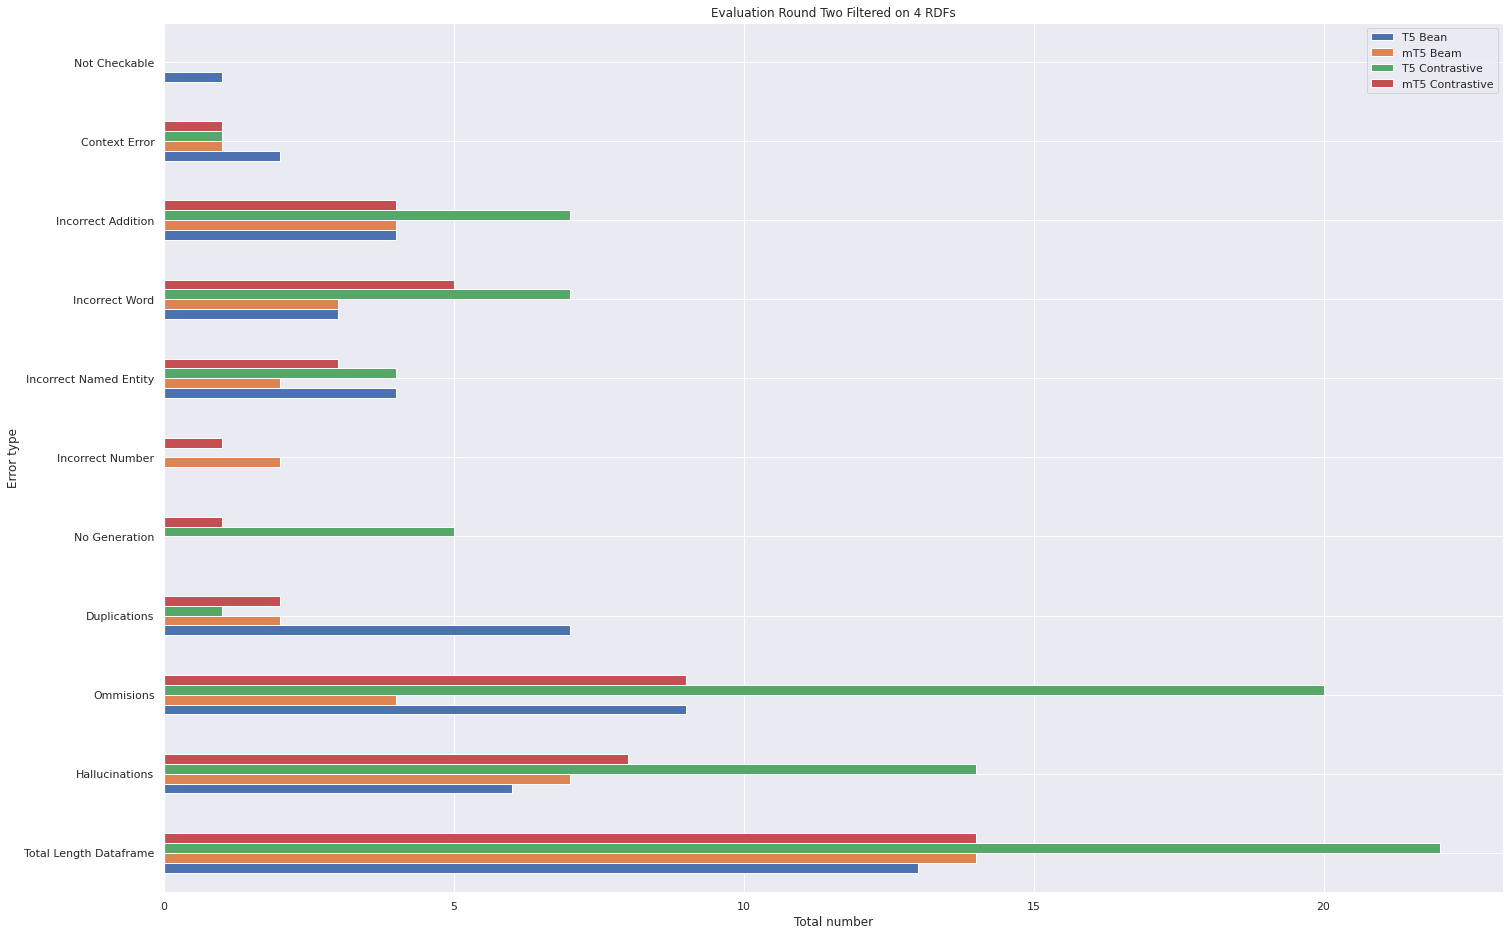

In [ ]:
run_plot(t5_beam_worst_df, mt5_beam_worst_df, t5_contrastive_worst_df, mt5_contrastive_worst_df, "Evaluation Round Two Filtered on 4 RDFs Input", count=4)

[ 1  2  4  5  8  6 10 12  3  7  9 13]
[1 3 2 4 8 5 6 7]
[ 1  2  6 10  4  3  8 12  5  7 14]
[1 2 4 3 5 8 6 9 7]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':


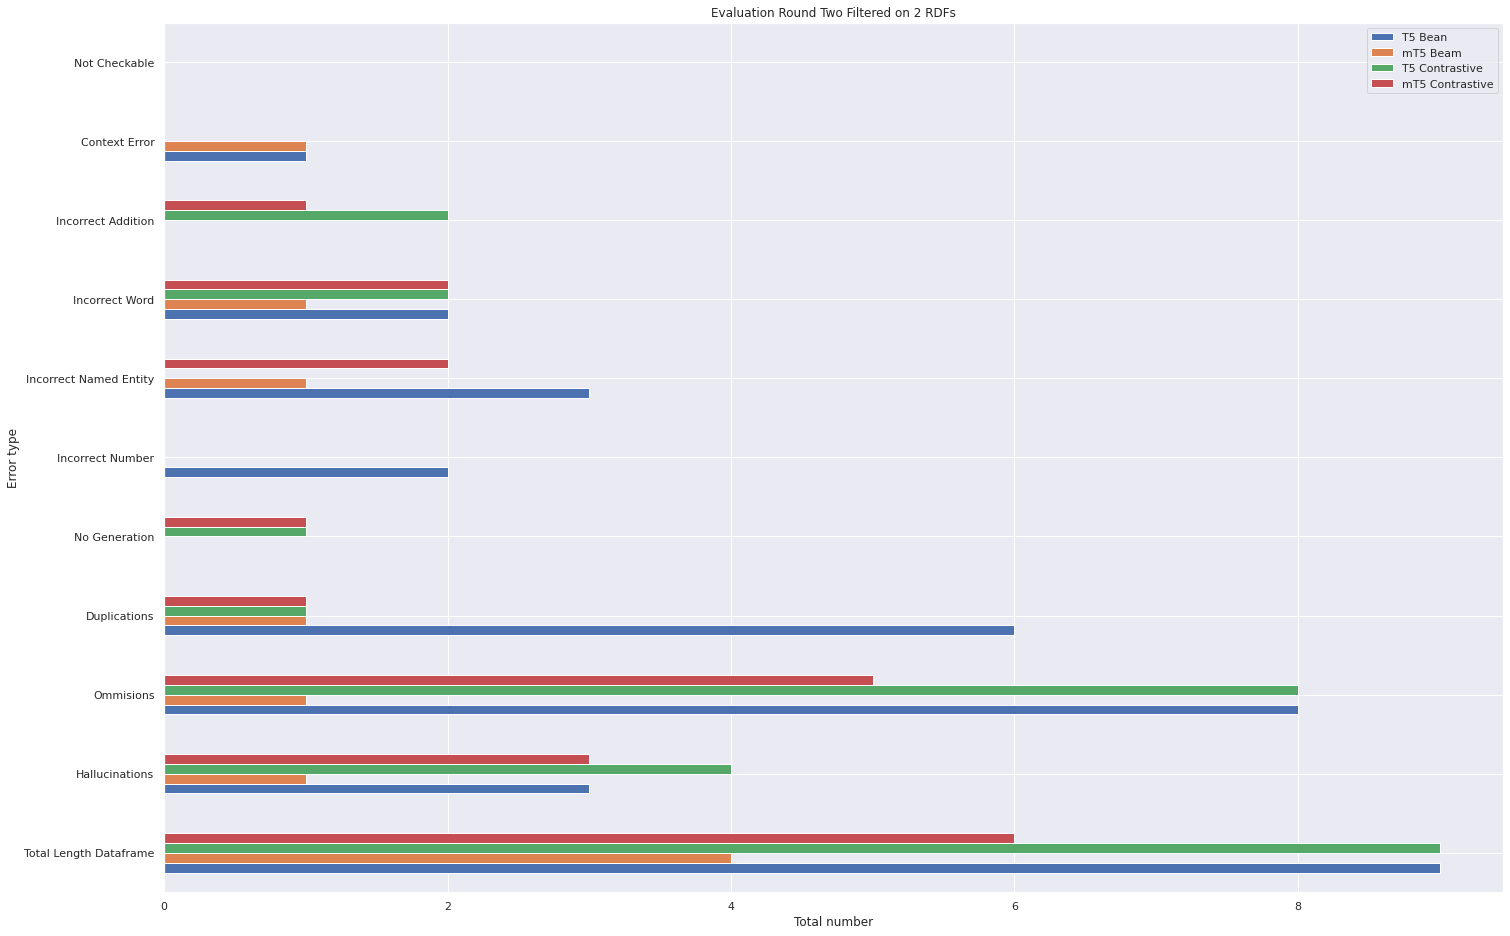

In [ ]:
run_plot(t5_beam_worst_df, mt5_beam_worst_df, t5_contrastive_worst_df, mt5_contrastive_worst_df, "Evaluation Round Two Filtered on 5 RDFs Input", count=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys


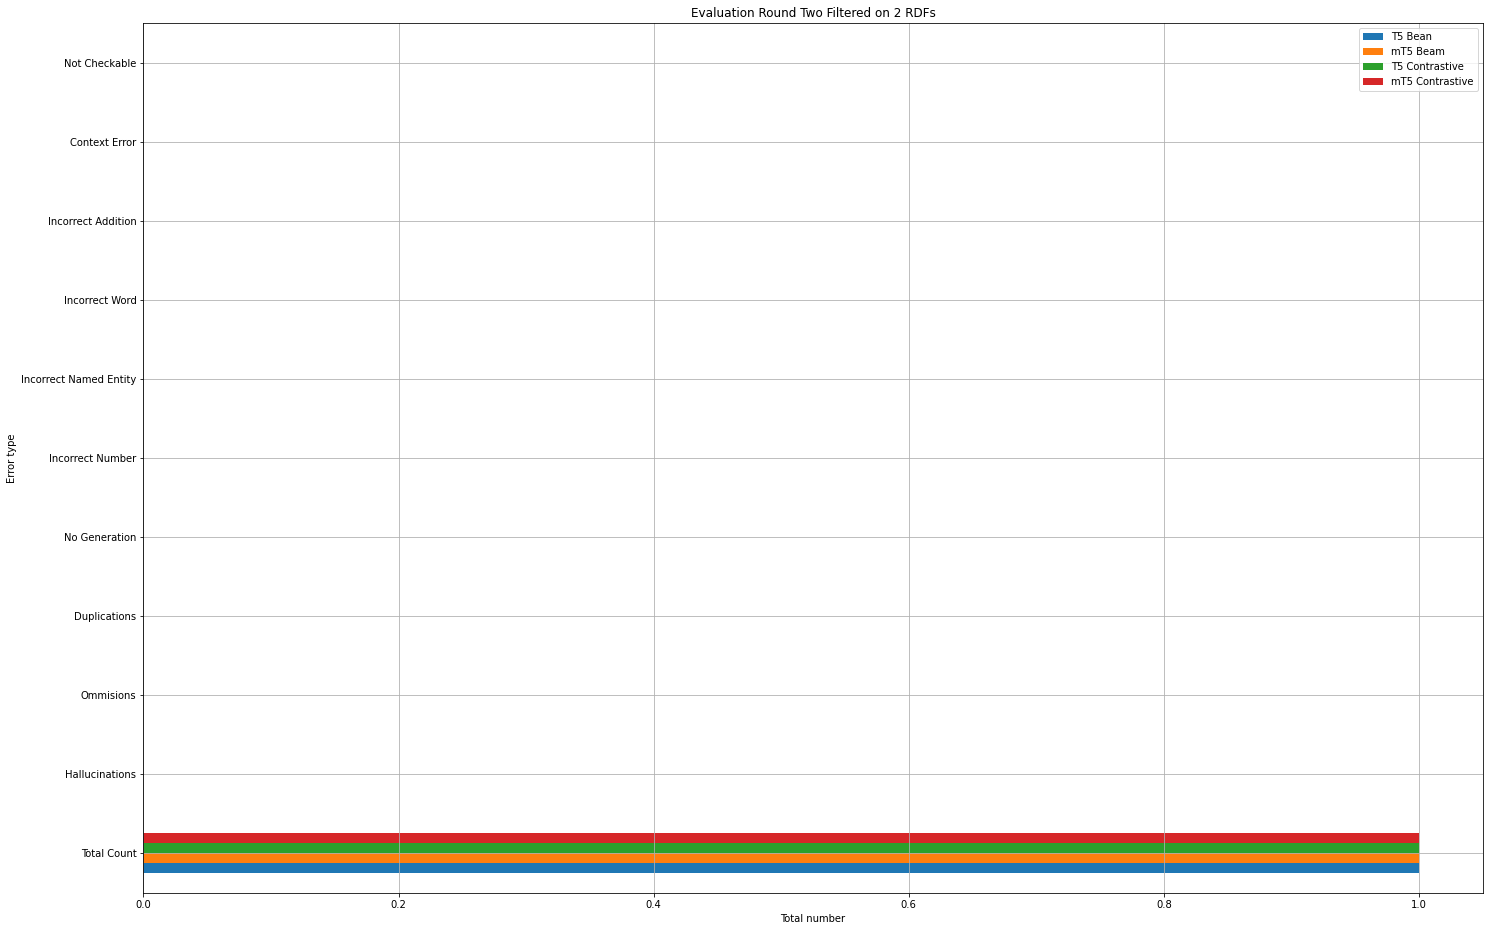

In [ ]:
run_plot(t5_beam_worst_df, mt5_beam_worst_df, t5_contrastive_worst_df, mt5_contrastive_worst_df, "Evaluation Round Two Filtered on 19 RDFs Input", count=19)

### BertViz evaluation

In [ ]:
from bertviz import model_view
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM

model_path = '/content/drive/MyDrive/MscThesis/Models/google_mt5-base/'

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path, output_attentions=True)

encoder_input_ids = tokenizer("['locationArea | overal', 'windSpeedBft | 6-7']", return_tensors="pt", add_special_tokens=True).input_ids

with tokenizer.as_target_tokenizer():
    decoder_input_ids = tokenizer("De wind is overal 6-7 Bft.", return_tensors="pt", add_special_tokens=True).input_ids

outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)

encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

Output hidden; open in https://colab.research.google.com to view.

### ECCO Evaluation

In [ ]:
# good source https://github.com/jalammar/ecco/blob/main/notebooks/Identifying%20model%20configuration.ipynb

import ecco
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSeq2SeqLM
hf_model_id = '/content/drive/MyDrive/MscThesis/Models/google_mt5-base/'
      

# 1- load the model the tokenizer
tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(hf_model_id)

#encoder.embed_tokens

model_config = {
    'embedding': "encoder.embed_tokens", 
    'type': 'enc-dec',
    'activations': ['layer1\.DenseReluDense\.wo'],
    'token_prefix': '',
    'partial_token_prefix': ''
}
ecco_model = ecco.from_pretrained(hf_model_id, 
                                  activations=True,
                                  model_config=model_config)

In [ ]:
text = ''' Now I ask you: \n what can be expected of man since he is a being endowed with strange qualities? Shower upon him every earthly blessing, drown him in a sea of happiness, so that nothing but bubbles of bliss can be seen on the surface; give him economic prosperity, such that he should have nothing else to do but sleep, eat cakes and busy himself with the continuation of his species, and even then out of sheer ingratitude, sheer spite, man would play you some nasty trick. He would even risk his cakes and would deliberately desire the most fatal rubbish, the most uneconomical absurdity, simply to introduce into all this positive good sense his fatal fantastic element. It is just his fantastic dreams, his vulgar folly that he will desire to retain, simply in order to prove to himself--as though that were so necessary-- that men still are men and not the keys of a piano, which the laws of nature threaten to control so completely that soon one will be able to desire nothing but by the calendar. And that is not all: even if man really were nothing but a piano-key, even if this were proved to him by natural science and mathematics, even then he would not become reasonable, but would purposely do something perverse out of simple ingratitude, simply to gain his point. And if he does not find means he will contrive destruction and chaos, will contrive sufferings of all sorts, only to gain his point! He will launch a curse upon the world, and as only man can curse (it is his privilege, the primary distinction between him and other animals), may be by his curse alone he will attain his object--that is, convince himself that he is a man and not a piano-key!'''

inputs = ecco_model.tokenizer([text], return_tensors="pt")
output = ecco_model(inputs)

#nmf_1 = output.run_nmf(n_components=8) 

#nmf_1.explore()

In [ ]:
text= "'locationArea | overal', 'timePoint | In de avond', 'windChange | af'"
output = ecco_model.generate(text, generate=10, do_sample=True)

In [ ]:
ecco_model.tokenizer("In de avond neemt de wind overal af")

In [ ]:
output.rankings_watch(watch=[563, 269, 259, 48571, 259, 25686, 270, 269, 25720, 259, 217529, 643, 1], position=37)

# Experiment Evaluation 

Extracting the same records as initial evaluation to compare the results of each experiment

In [ ]:
# open a file, where you stored the pickled data
file = open('/content/drive/MyDrive/MscThesis/Generation_docs/pickles/mT5_all_beamSearch_one_generations.pickle', 'rb')
# dump information to that file
mt5_df = pickle.load(file)
# close the file
file.close()

In [ ]:
mt5_df= mt5_df.sort_values(["BartScore", "Meteor", "RougeL"])

mt5_worst_200 = mt5_df.iloc[:200]

# Save the indexes so that we can retrieve the same sentences in different dataframes
index_ids = mt5_worst_200.index

### Filtering and Retrieving the 200 worst predictions from the original manual evaluation for the Elongated model run

In [ ]:
Elon_full_testset = pd.DataFrame()
Elon_full_testset["RDF"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Parent_test/Elongated_mt5/google_mt5-base_rdfs.txt', sep='delimiter', header=None, encoding='UTF-8')
Elon_full_testset["Predictions"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Parent_test/Elongated_mt5/google_mt5-base_decode_predictions.txt', sep='delimiter', header=None, encoding='UTF-8')
Elon_full_testset['Real'] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Parent_test/Elongated_mt5/google_mt5-base_true_articles.txt', sep='delimiter', header=None, encoding='UTF-8')

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
Elon_full_testset

,RDF,Predictions,Real
0,"[(""'accidentAddress"", ""southeast Houston'""), (...",The violent shooting happened overnight in sou...,A bar fight ends in a violent shooting overnig...
1,"[(""'accidentAddress"", ""La Revolucion Sports Ba...",Police say at least two men were shot at La Re...,Police say at least two men were shot at La Re...
2,"[(""'victimNumber"", ""One'""), (""'victimNumber"", ...","One of the victims is in critical condition, a...","One person is in critical condition, and as ma..."
3,"[(""'hospitalName"", ""Bayshore Medical Center'"")...",Two people were transported to Bayshore Medica...,Two of the victims showed up seeking help at B...
4,"[(""'suspectStatus"", ""on the run'""), (""'suspect...",The suspect was a baby blue Chrysler 300 on th...,"The shooter is on the run, driving away in a b..."
...,...,...,...
3023,"[(""'cloudAmount"", ""zwaar bewolkt'""), (""'locati...",Woensdag overdag is het zwaar bewolkt en voora...,Woensdag overdag is het zwaar bewolkt met voor...
3024,"[(""'compassDirection"", ""zuidwesten'""), (""'time...",In de middag gaat het van het zuidwesten uit r...,In de middag gaat het van het zuidwesten uit r...
3025,"[(""'timePoint"", ""In de avond'""), (""'weatherCha...",In de avond wordt het geleidelijk droog.,In de avond wordt het geleidelijk droog.
3026,"[(""'temperatureCelsius"", ""17°C'""), (""'timePoin...",De middagtemperatuur ligt rond 17°C.,De middagtemperatuur ligt rond 17°C.


In [ ]:
filtered_Elon_df = Elon_full_testset.filter(items = index_ids, axis=0)

In [ ]:
filtered_Elon_df

,RDF,Predictions,Real
2189,"[(""'locationName"", ""New York'"")]",New York,New York - De argumenten voor een renteverlagi...
2472,"[(""'companyName"", ""CNBC'"")]",De aandelenbeurzen op CNBC waren de grootste s...,Het bedrijf moet mensen beter toegang bieden t...
2487,"[(""'locationName"", ""Wall Street'"")]",Wall Street,Een dag na een uiterst beroerde sessie maakt W...
19,"[(""'victimAge Group"", ""minor'""), (""'victimGend...",The female victim was a minor Spanish female.,A Hispanic female minor
2173,"[(""'companyName"", ""Sandd'"")]",Sandd,De overname van rivaal Sandd drukte duidelijk ...
...,...,...,...
2118,"[(""'chanceForName"", ""Abdul Ajagun'""), (""'chanc...",De Zwolse Abdul Ajagun kreeg een afzwaaier.,Op de Zwolse helft produceerde Abdul Ajagun ee...
1639,"[(""'suspectVehicle"", ""automobilist'"")]",De automobilist reed op de verkeerde weghelft.,Het is niet bekend of de automobilist te hard ...
1155,"[(""'LOC"", ""Israel'"")]",Israel is expected to join the negotiations.,"To date, there is virtually no market-making i..."
921,"[(""'ORG"", ""DIB'""), (""'ORG"", ""Noor Bank'"")]","Noor Bank, DIB and Noor Bank are all listed on...",* DIB shareholders approve Noor Bank acquisition


In [ ]:
filtered_Elon_df.to_csv(r'/content/drive/MyDrive/MscThesis/filtered_Elon_worst_200_df.csv', index = False, header=True, encoding='utf-8')

###  Filtering and Retrieving the 200 worst predictions from the original manual evaluation for the Augmented model run

In [ ]:
Aug_full_testset = pd.DataFrame()
Aug_full_testset["RDF"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Parent_test/Augmented_mt5/google_mt5-base_rdfs.txt', sep='delimiter', header=None, encoding='UTF-8')
Aug_full_testset["Predictions"] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Parent_test/Augmented_mt5/google_mt5-base_decode_predictions.txt', sep='delimiter', header=None, encoding='UTF-8')
Aug_full_testset['Real'] = pd.read_csv(f'/content/drive/MyDrive/MscThesis/Parent_test/Augmented_mt5/google_mt5-base_true_articles.txt', sep='delimiter', header=None, encoding='UTF-8')

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
Aug_full_testset

,RDF,Predictions,Real
0,"[(""'accidentAddress"", ""southeast Houston'""), (...",The violent shooting happened southeast Housto...,A bar fight ends in a violent shooting overnig...
1,"[(""'accidentAddress"", ""La Revolucion Sports Ba...",The victims were at least two men who were sho...,Police say at least two men were shot at La Re...
2,"[(""'victimNumber"", ""One'""), (""'victimNumber"", ...","One of the victims is in critical condition, p...","One person is in critical condition, and as ma..."
3,"[(""'hospitalName"", ""Bayshore Medical Center'"")...",Two people were transported to Bayshore Medica...,Two of the victims showed up seeking help at B...
4,"[(""'suspectStatus"", ""on the run'""), (""'suspect...",The baby blue Chrysler 300 is on the run.,"The shooter is on the run, driving away in a b..."
...,...,...,...
3023,"[(""'cloudAmount"", ""zwaar bewolkt'""), (""'locati...",Woensdag overdag is het zwaar bewolkt en komt ...,Woensdag overdag is het zwaar bewolkt met voor...
3024,"[(""'compassDirection"", ""zuidwesten'""), (""'time...",In de middag gaat het van het zuidwesten uit r...,In de middag gaat het van het zuidwesten uit r...
3025,"[(""'timePoint"", ""In de avond'""), (""'weatherCha...",In de avond wordt het geleidelijk droog.,In de avond wordt het geleidelijk droog.
3026,"[(""'temperatureCelsius"", ""17°C'""), (""'timePoin...",De middagtemperatuur ligt rond 17°C.,De middagtemperatuur ligt rond 17°C.


In [ ]:
filtered_Aug_df = Aug_full_testset.filter(items = index_ids, axis=0)

In [ ]:
filtered_Aug_df

,RDF,Predictions,Real
2189,"[(""'locationName"", ""New York'"")]",New York,New York - De argumenten voor een renteverlagi...
2472,"[(""'companyName"", ""CNBC'"")]",CNBC is de grootste stijger van de beurs in de...,Het bedrijf moet mensen beter toegang bieden t...
2487,"[(""'locationName"", ""Wall Street'"")]",Wall Street,Een dag na een uiterst beroerde sessie maakt W...
19,"[(""'victimAge Group"", ""minor'""), (""'victimGend...",A female female from the Cuyahoga County Juven...,A Hispanic female minor
2173,"[(""'companyName"", ""Sandd'"")]",Sandd was de grootste stijger in de eredivisie.,De overname van rivaal Sandd drukte duidelijk ...
...,...,...,...
2118,"[(""'chanceForName"", ""Abdul Ajagun'""), (""'chanc...","De Zwolse afzwaaier was Abdul Ajagun, die op e...",Op de Zwolse helft produceerde Abdul Ajagun ee...
1639,"[(""'suspectVehicle"", ""automobilist'"")]",De automobilist reed waarschijnlijk zo'n 80 ki...,Het is niet bekend of de automobilist te hard ...
1155,"[(""'LOC"", ""Israel'"")]",Israel would be among the biggest terrorist ca...,"To date, there is virtually no market-making i..."
921,"[(""'ORG"", ""DIB'""), (""'ORG"", ""Noor Bank'"")]",DIB and Noor Bank are among the biggest indice...,* DIB shareholders approve Noor Bank acquisition


In [ ]:
filtered_Aug_df.to_csv(r'/content/drive/MyDrive/MscThesis/filtered_Aug_worst_200_df.csv', index = False, header=True, encoding='utf-8')